### Determining Trade Union Status
#### Kevin Wang

##### In this project, I will create several models in order to classify an individual as leaving or not leaving a hypothetical trade union, the United Data Scientists Union (UDSU). The original dataset includes one target binary character variable, LeftUnion, and 20 features including gender, Management, USAcitizen, MonthsInUnion, MonthlyDues, several unspecified features, and more. After processing the data, I will use principal component analysis to reduce the dimensions of my features and eliminate multicollinearity before fitting several models to my transformed dataset. Finally, I will compare my models based on their prediction accuracy. 

### Part 1: Load dataset and import libraries

In [1]:
library(ggplot2)
library(caret)
library(neuralnet)
library(patchwork)
library(repr)
library(factoextra)
library(psych)
# devtools::install_github("selva86/InformationValue")
library(InformationValue)
library(randomForest)
library(e1071)

Loading required package: lattice

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: 'psych'


The following objects are masked from 'package:ggplot2':

    %+%, alpha



Attaching package: 'InformationValue'


The following objects are masked from 'package:caret':

    confusionMatrix, precision, recall, sensitivity, specificity


randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:psych':

    outlier


The following object is masked from 'package:ggplot2':

    margin




In [2]:
# Will split the train dataset into training and validation sets later
train <- read.csv("~/Maryville Courses/DSCI 508/Projects/Final Project/kevin-TRAIN.csv")
head(train)

,ID,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,FeatureC,⋯,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,Kevin1,Male,0,No,No,18,Yes,Yes,Fiber optic,No,⋯,Yes,No,Yes,No,One year,Yes,Credit card (automatic),90,1633,No
2,Kevin2,Male,0,Yes,Yes,47,Yes,Yes,DSL,No,⋯,No,No,No,No,Month-to-month,No,Electronic check,54,2538,No
3,Kevin3,Female,0,Yes,Yes,13,Yes,No,Dial-in,Maryville,⋯,Maryville,Maryville,Maryville,Maryville,Two year,No,Mailed check,20,265,No
4,Kevin4,Female,0,No,No,56,Yes,Yes,Fiber optic,No,⋯,No,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),105,5917,No
5,Kevin5,Male,0,No,No,67,Yes,No,DSL,No,⋯,No,Yes,No,No,Two year,No,Bank transfer (automatic),51,3260,No
6,Kevin6,Male,0,No,No,30,Yes,No,DSL,Yes,⋯,Yes,No,No,No,Two year,Yes,Mailed check,56,1654,No


In [3]:
str(train)

'data.frame':	999 obs. of  21 variables:
 $ ID              : chr  "Kevin1" "Kevin2" "Kevin3" "Kevin4" ...
 $ gender          : chr  "Male" "Male" "Female" "Female" ...
 $ Management      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ USAcitizen      : chr  "No" "Yes" "Yes" "No" ...
 $ Married         : chr  "No" "Yes" "Yes" "No" ...
 $ MonthsInUnion   : int  18 47 13 56 67 30 69 23 37 46 ...
 $ ContinuingEd    : chr  "Yes" "Yes" "Yes" "Yes" ...
 $ FeatureA        : chr  "Yes" "Yes" "No" "Yes" ...
 $ Connectivity    : chr  "Fiber optic" "DSL" "Dial-in" "Fiber optic" ...
 $ FeatureC        : chr  "No" "No" "Maryville" "No" ...
 $ FeatureD        : chr  "No" "Yes" "Maryville" "Yes" ...
 $ FeatureE        : chr  "Yes" "No" "Maryville" "No" ...
 $ FeatureF        : chr  "No" "No" "Maryville" "Yes" ...
 $ FeatureG        : chr  "Yes" "No" "Maryville" "Yes" ...
 $ FeatureB        : chr  "No" "No" "Maryville" "Yes" ...
 $ DuesFrequency   : chr  "One year" "Month-to-month" "Two year" "Month-to-month" ...
 

##### Most of the variables are characters other than MonthsInUnion, MonthlyDues, and TotalDues being numeric. I will remove from train the ID column as it is irrelevant to union status and the TotalDues column as it is captured by MonthsInUnion and MonthlyDues. Then, I will convert management and all character variables to factors. 

In [4]:
train[c('ID','TotalDues')] <- list(NULL)

In [5]:
# Change management and character variables to factors
cols <- c('gender','Management','USAcitizen','Married','ContinuingEd','FeatureA','Connectivity','FeatureC','FeatureD','FeatureE','FeatureF','FeatureG','FeatureB',
          'DuesFrequency','PaperlessBilling','PaymentMethod')
train[cols] <- lapply(train[cols],factor)
# Change response column LeftUnion into dummy variable
train$LeftUnion <- factor(ifelse(train$LeftUnion == 'No', 0, 1))
summary(train)

    gender    Management USAcitizen Married   MonthsInUnion    ContinuingEd
 Female:515   0:847      No :537    No :717   Min.   :  1.00   No : 80     
 Male  :484   1:152      Yes:462    Yes:282   1st Qu.:  8.00   Yes:919     
                                              Median : 30.00               
                                              Mean   : 34.55               
                                              3rd Qu.: 58.00               
                                              Max.   :616.00               
      FeatureA        Connectivity      FeatureC        FeatureD  
 Maryville: 80   Dial-in    : 96   Maryville:212   Maryville:212  
 No       :471   DSL        :339   No       :509   No       :411  
 Yes      :448   Fiber optic:448   Yes      :278   Yes      :376  
                 onlyViaER  :116                                  
                                                                  
                                                                  

##### I confirm that all character variables have been successfully converted to factors, with the distribution of levels for each factor variable and the summary statistics of numeric variables shown above. Finally, I will check the dataset for any missing values. 

In [6]:
# Check to see if any missing values
train[!complete.cases(train),]

gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,FeatureC,FeatureD,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,LeftUnion
<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>


##### Note there are no missing values. If there were missing factor values, I would replace with the mode. If there were any missing numeric values, I would replace with the median. Next, I explore the dataset further through graphs. 

### Part 2: Graphs
##### Most of the features are factors, and so I begin by examining the two numeric features: MonthsInUnion and MonthlyDues.

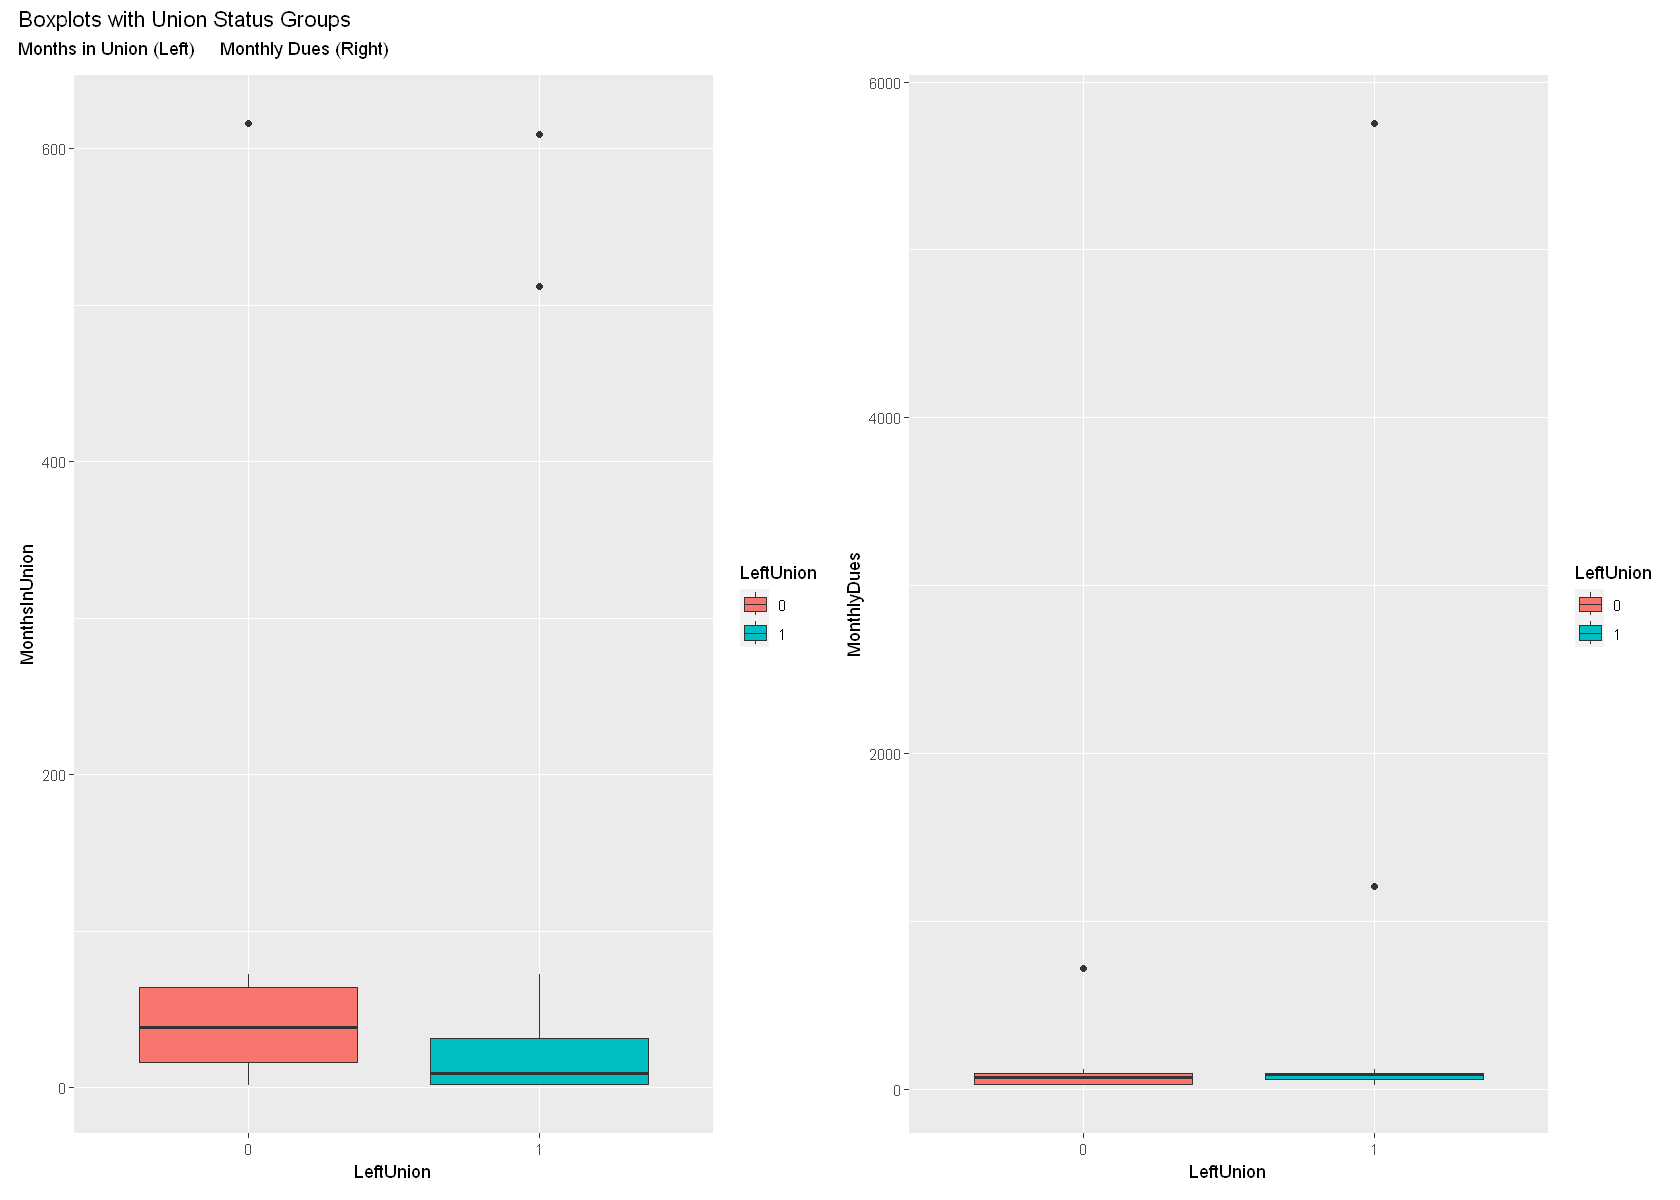

In [7]:
# Box and Whisker plot
# Patchwork library used to better format plot layouts
# Repr library used to easily format graph grid sizes
options(repr.plot.width=14, repr.plot.height=10)
boxplot1 <- ggplot(train, aes(x = LeftUnion, y = MonthsInUnion, fill = LeftUnion)) + geom_boxplot()
boxplot2 <- ggplot(train, aes(x = LeftUnion, y = MonthlyDues, fill = LeftUnion)) + geom_boxplot()
patchwork1 <- boxplot1 + boxplot2 
patchwork1 + plot_annotation(title='Boxplots with Union Status Groups',
                             subtitle= 'Months in Union (Left)     Monthly Dues (Right)')

##### There are 3 outliers for both MonthsInUnion and MonthlyDues. I will delete the outliers from train, using Excel to find the rows. Note that the outliers belong to the same 3 observations, so 3 rows will be removed. 

In [8]:
train <- train[-c(227, 494, 909),]
nrow(train)
summary(train)

[1] 996

    gender    Management USAcitizen Married   MonthsInUnion   ContinuingEd
 Female:514   0:844      No :535    No :715   Min.   : 1.00   No : 80     
 Male  :482   1:152      Yes:461    Yes:281   1st Qu.: 8.00   Yes:916     
                                              Median :30.00               
                                              Mean   :32.91               
                                              3rd Qu.:57.25               
                                              Max.   :72.00               
      FeatureA        Connectivity      FeatureC        FeatureD  
 Maryville: 80   Dial-in    : 96   Maryville:211   Maryville:211  
 No       :469   DSL        :338   No       :507   No       :409  
 Yes      :447   Fiber optic:447   Yes      :278   Yes      :376  
                 onlyViaER  :115                                  
                                                                  
                                                                  
      

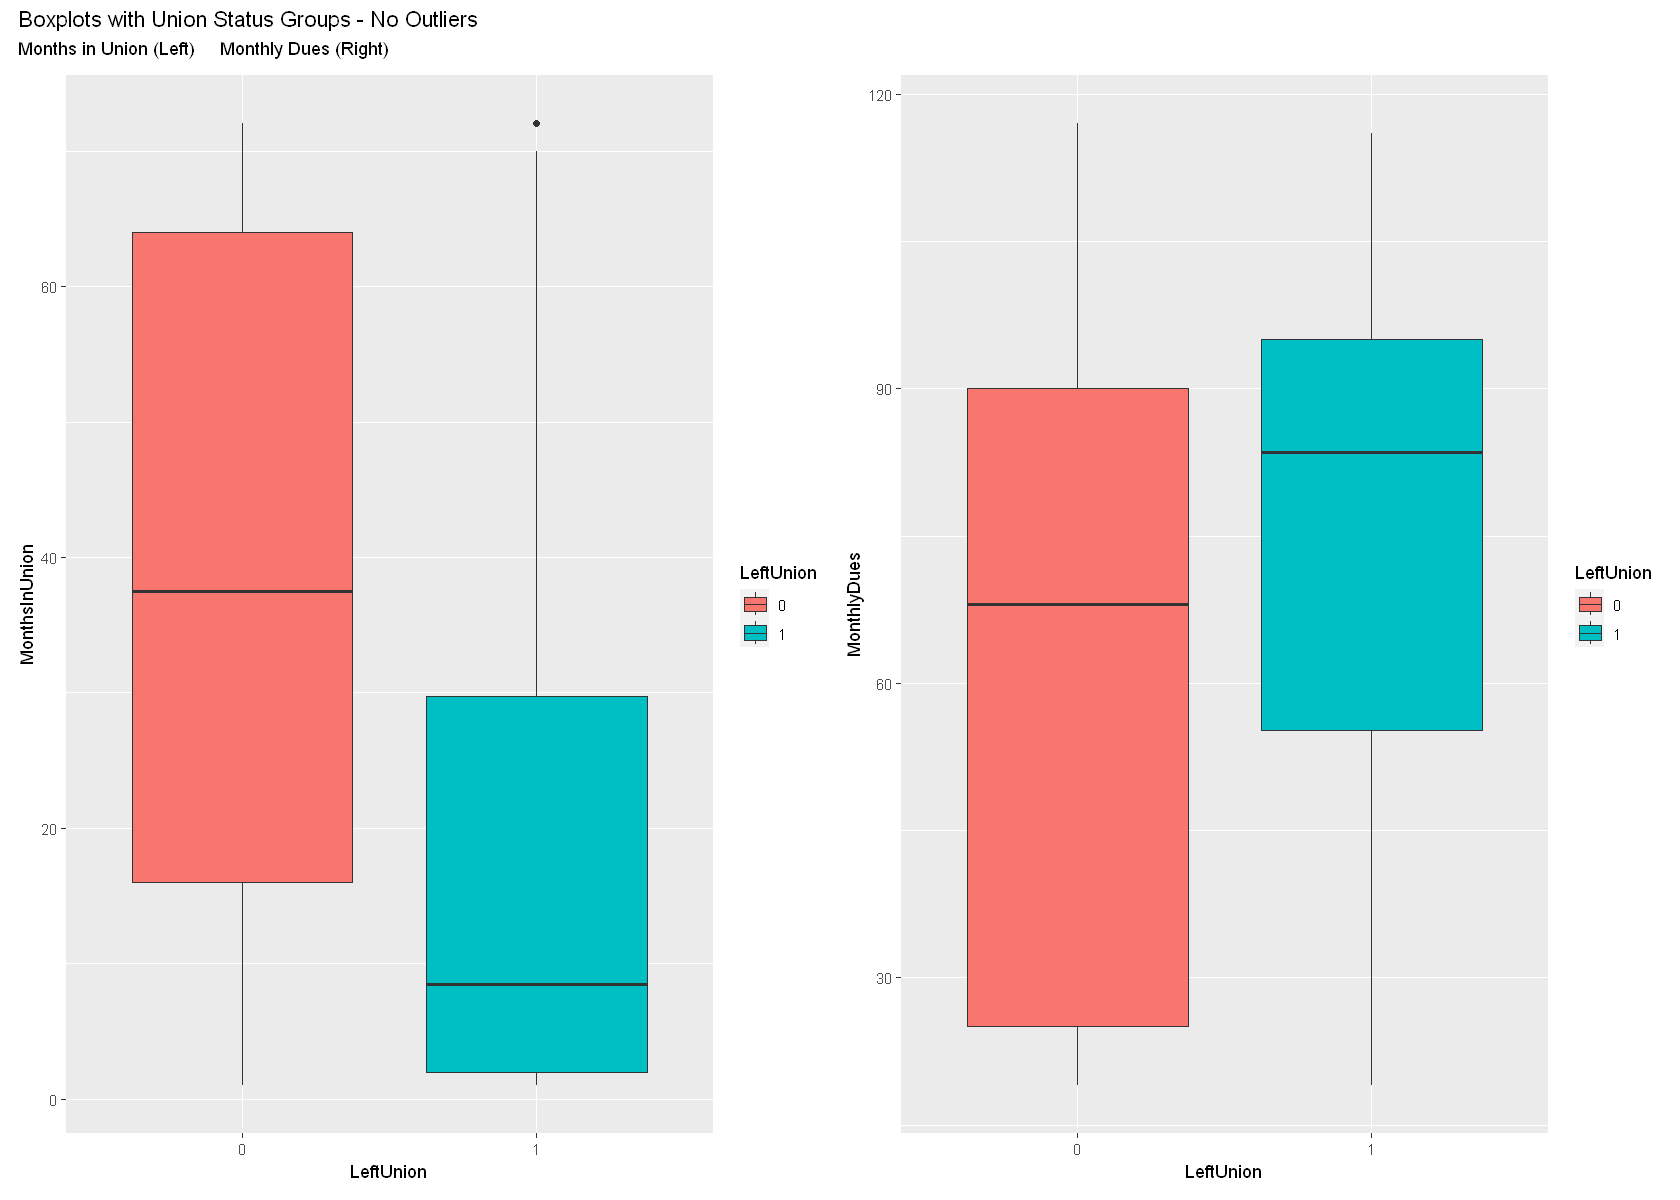

In [9]:
# Box and Whisker plot with outliers removed
boxplot3 <- ggplot(train, aes(x = LeftUnion, y = MonthsInUnion, fill = LeftUnion)) + geom_boxplot()
boxplot4 <- ggplot(train, aes(x = LeftUnion, y = MonthlyDues, fill = LeftUnion)) + geom_boxplot()
patchwork2 <- boxplot3 + boxplot4 
patchwork2 + plot_annotation(title='Boxplots with Union Status Groups - No Outliers',
                             subtitle= 'Months in Union (Left)     Monthly Dues (Right)')

##### The boxplots look much better now, with only one outlier left representing an individual who left the union but was a long time member. As this outlier is not as egregious, I will leave it in the dataset. From the boxplots, note that people who were members for a shorter time are more likely to leave and people who pay higher dues are also more likely to leave the union. I came to this conclusion based on the difference in notches, which denotes that the medians of the two groups differ. 

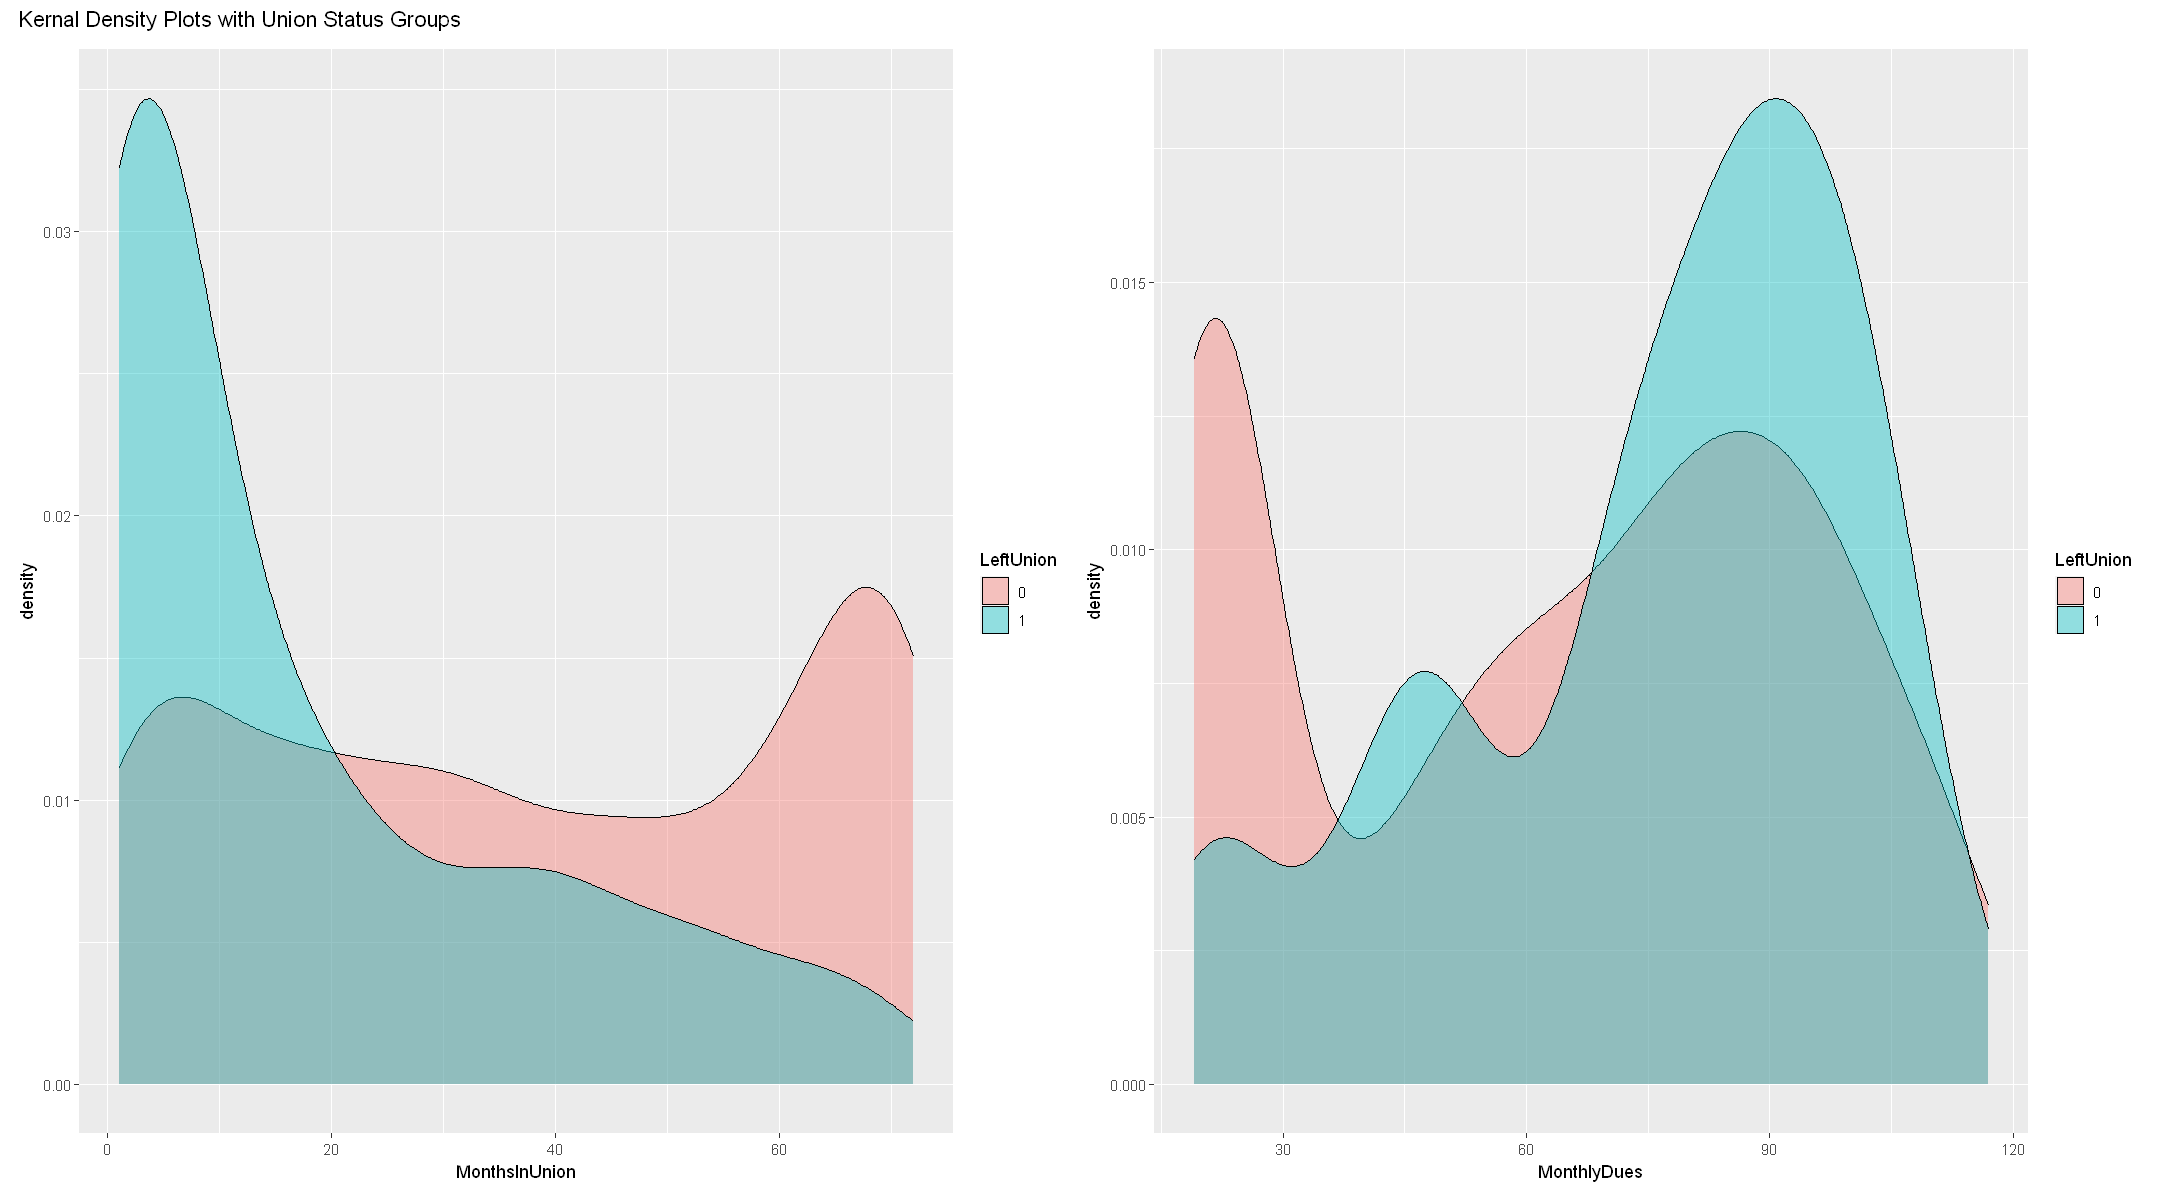

In [10]:
# Kernal density plots
options(repr.plot.width=18, repr.plot.height=10)
kernal1 <- ggplot(train, aes(x = MonthsInUnion, fill = LeftUnion)) + geom_density(alpha=.4)
kernal2 <- ggplot(train, aes(x = MonthlyDues, fill = LeftUnion)) + geom_density(alpha=.4)
patchwork3 <- kernal1+kernal2
patchwork3 + plot_annotation(title='Kernal Density Plots with Union Status Groups')

##### The kernal density plots confirm my conclusions from the boxplots. The left graph shows individuals who left the union are more likely to be recent members. The right graph shows individuals who left the union are more likely to have higher monthly dues. 

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


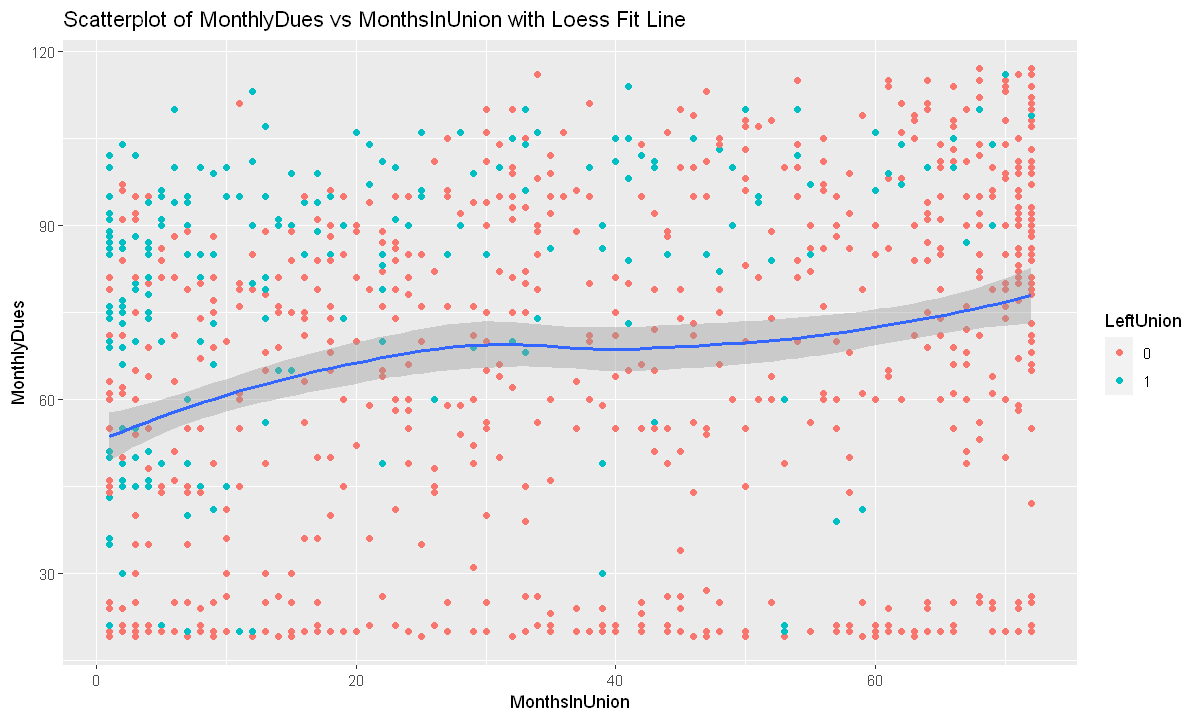

In [11]:
# Scatterplot of MonthlyDues vs MonthsInUnion
options(repr.plot.width=10, repr.plot.height=6)
ggplot(train, aes(MonthsInUnion, MonthlyDues)) + geom_point(aes(color=LeftUnion)) + geom_smooth() + 
ggtitle('Scatterplot of MonthlyDues vs MonthsInUnion with Loess Fit Line')

##### The loess line (smoothed nonparametric fit) shows a positive relationship between MonthsInUnion and MonthlyDues. Note that individuals who left the union are concentrated in the upper left, representing high MonthlyDues and low MonthsInUnion. 

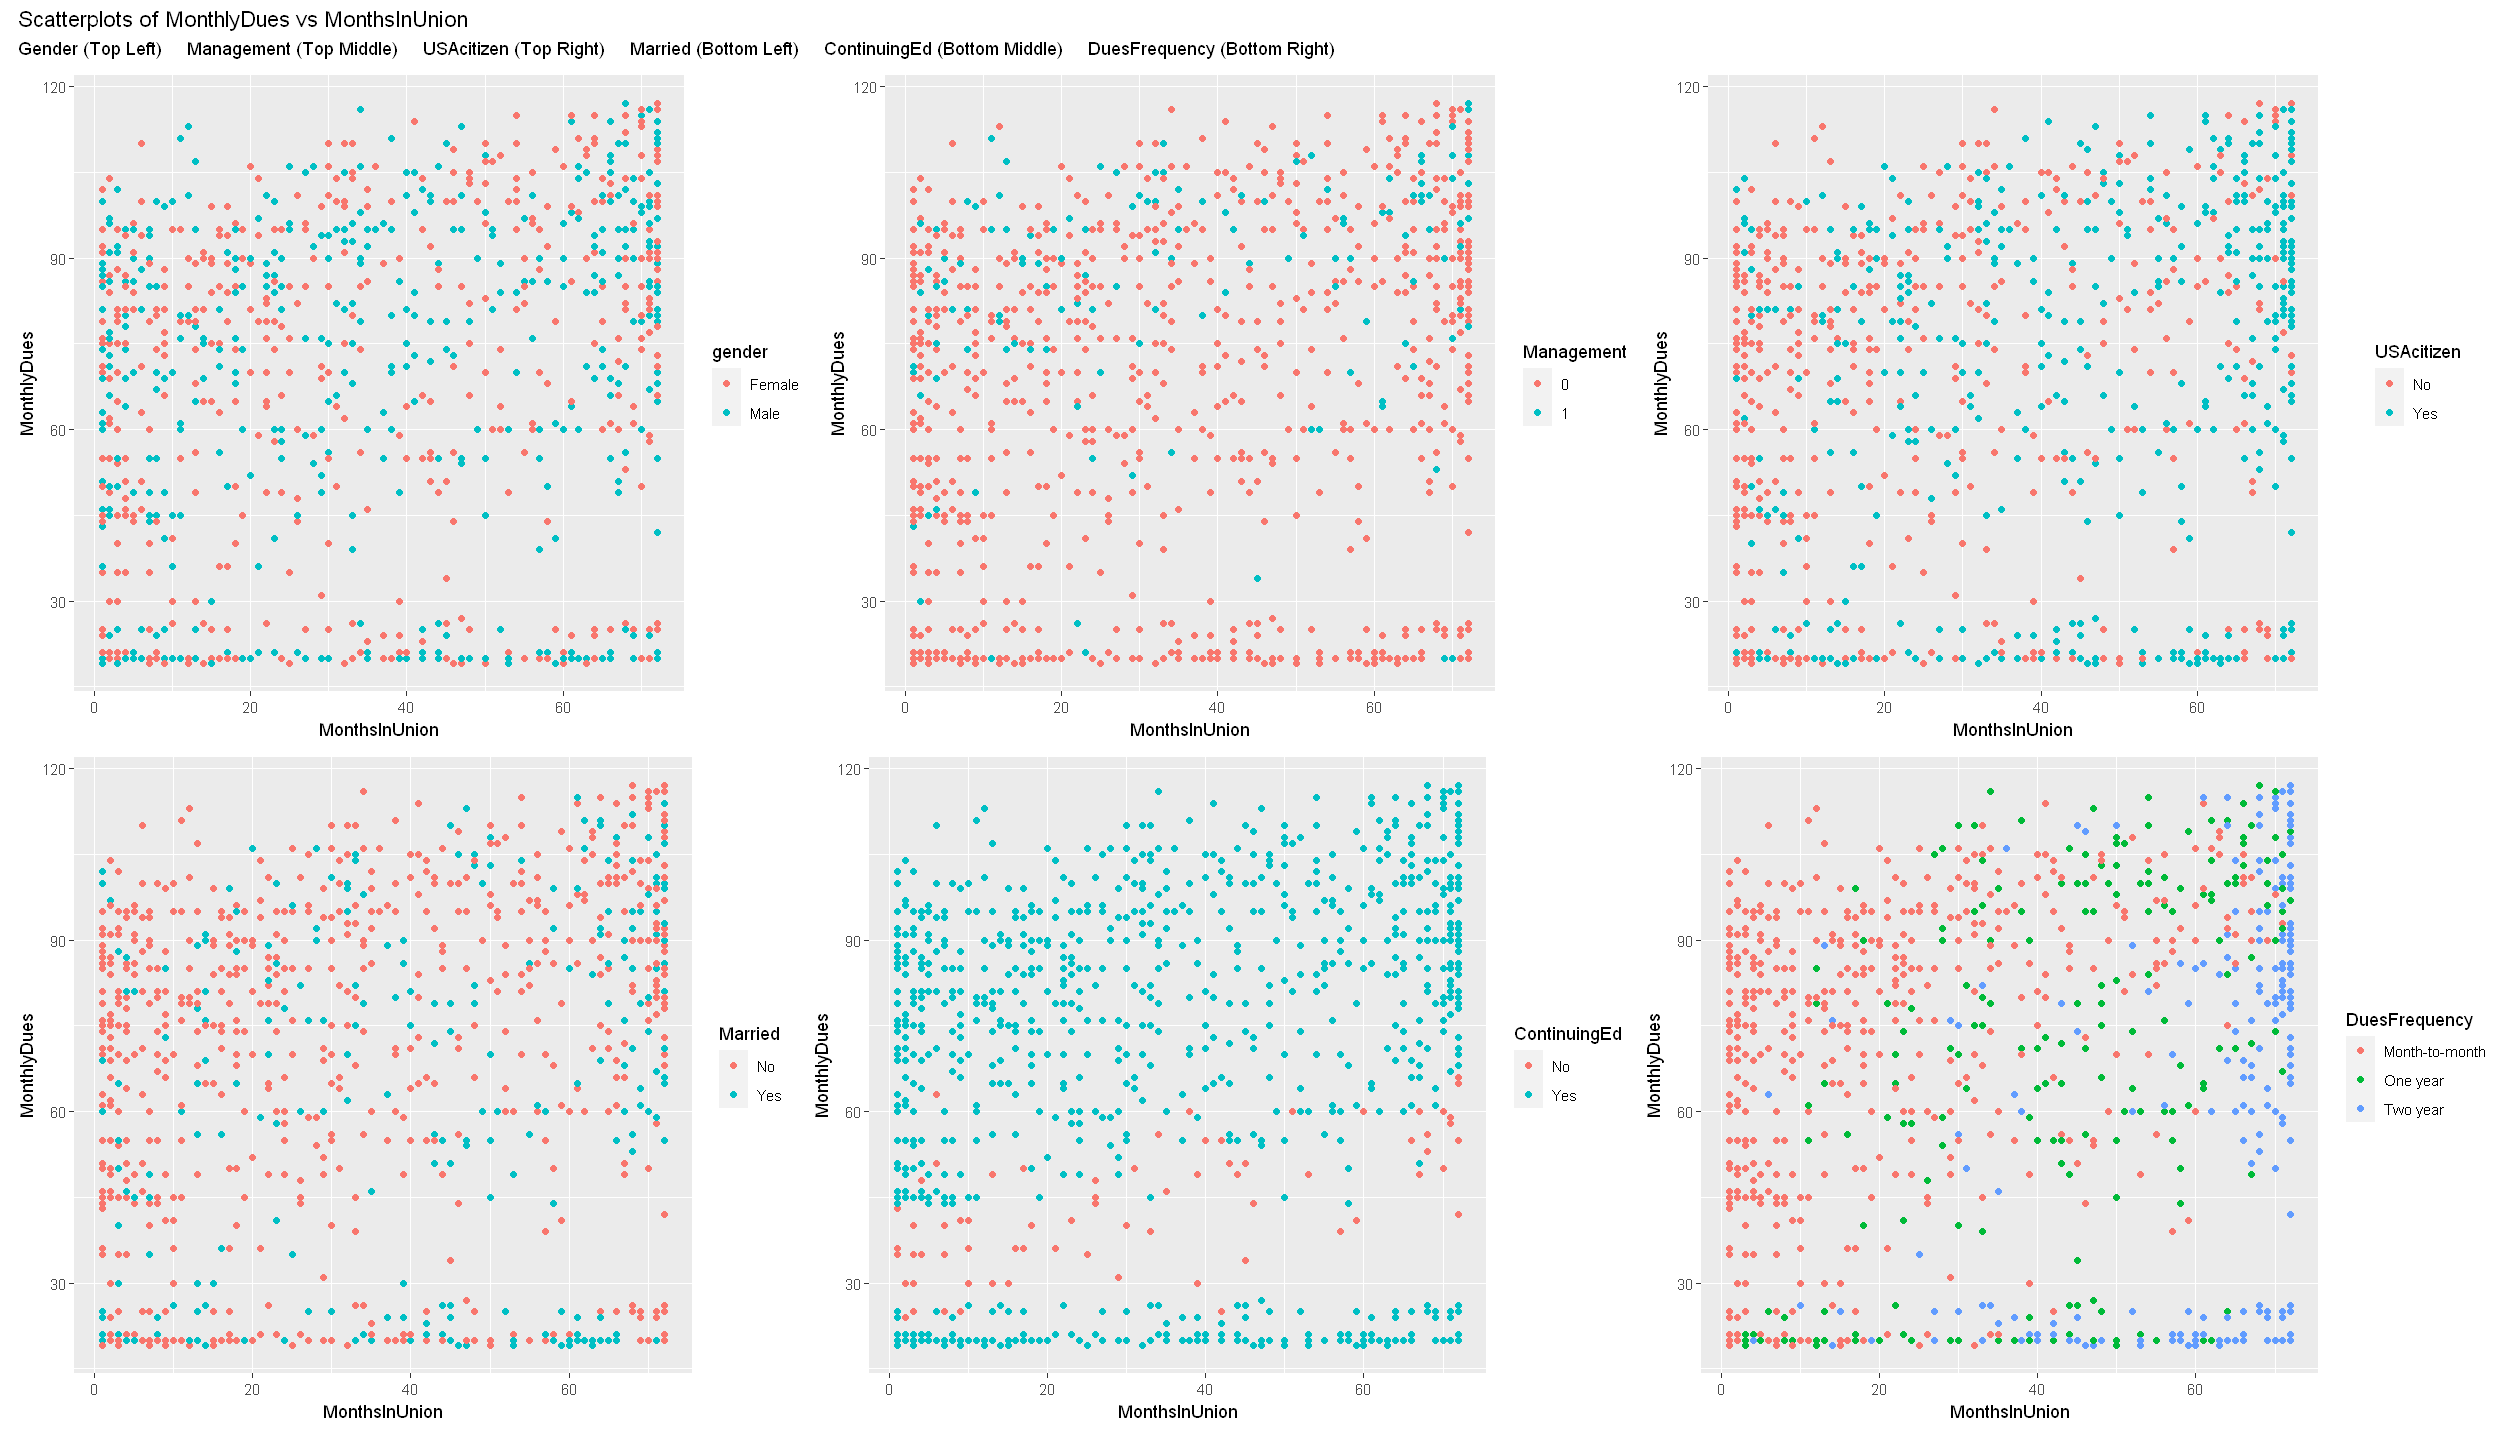

In [12]:
options(repr.plot.width=21, repr.plot.height=12)
scatterplot1 <- ggplot(train, aes(MonthsInUnion, MonthlyDues)) + geom_point(aes(color=gender))
scatterplot2 <- ggplot(train, aes(MonthsInUnion, MonthlyDues)) + geom_point(aes(color=Management)) 
scatterplot3 <- ggplot(train, aes(MonthsInUnion, MonthlyDues)) + geom_point(aes(color=USAcitizen))
scatterplot4 <- ggplot(train, aes(MonthsInUnion, MonthlyDues)) + geom_point(aes(color=Married))
scatterplot5 <- ggplot(train, aes(MonthsInUnion, MonthlyDues)) + geom_point(aes(color=ContinuingEd))
scatterplot6 <- ggplot(train, aes(MonthsInUnion, MonthlyDues)) + geom_point(aes(color=DuesFrequency))

patchwork4 <- (scatterplot1+scatterplot2+scatterplot3)/(scatterplot4+scatterplot5+scatterplot6)
patchwork4 + plot_annotation(title='Scatterplots of MonthlyDues vs MonthsInUnion',
                             subtitle= 'Gender (Top Left)     Management (Top Middle)     USAcitizen (Top Right)     Married (Bottom Left)     ContinuingEd (Bottom Middle)     DuesFrequency (Bottom Right)')

##### I changed the groups from LeftUnion to gender, Management, USAcitizen, Married, ContinuingEd, and DuesFrequency to see if there are any notable patterns. There appear to be no notable patterns within gender and Married. The Management scatterplot shows managers concentrated in the upper half of the plot, which means managers on average have higher MonthlyDues than non-managers. The USAcitizen graph has a concentration of citizens in the upper right quadrant, showing that individuals who pay more dues and have been in the union longer are more likely to be USA citizens. The ContinuingEd graph shows that the small percentage of 'No' observations are concentrated in the lower half of the plot, denoting low MonthlyDues. Finally, the DuesFrequency graph shows that newer members are more likely to pay month-to-month, middle members are more likely to pay yearly, and long-term members are more likely to pay every two years. 

##### To better see the patterns I found from the scatterplots, I will create jittered strip plots of MonthsInUnion and MonthlyDues grouped by LeftUnion, Management, USAcitizen, ContinuingEd, and DuesFrequency.  

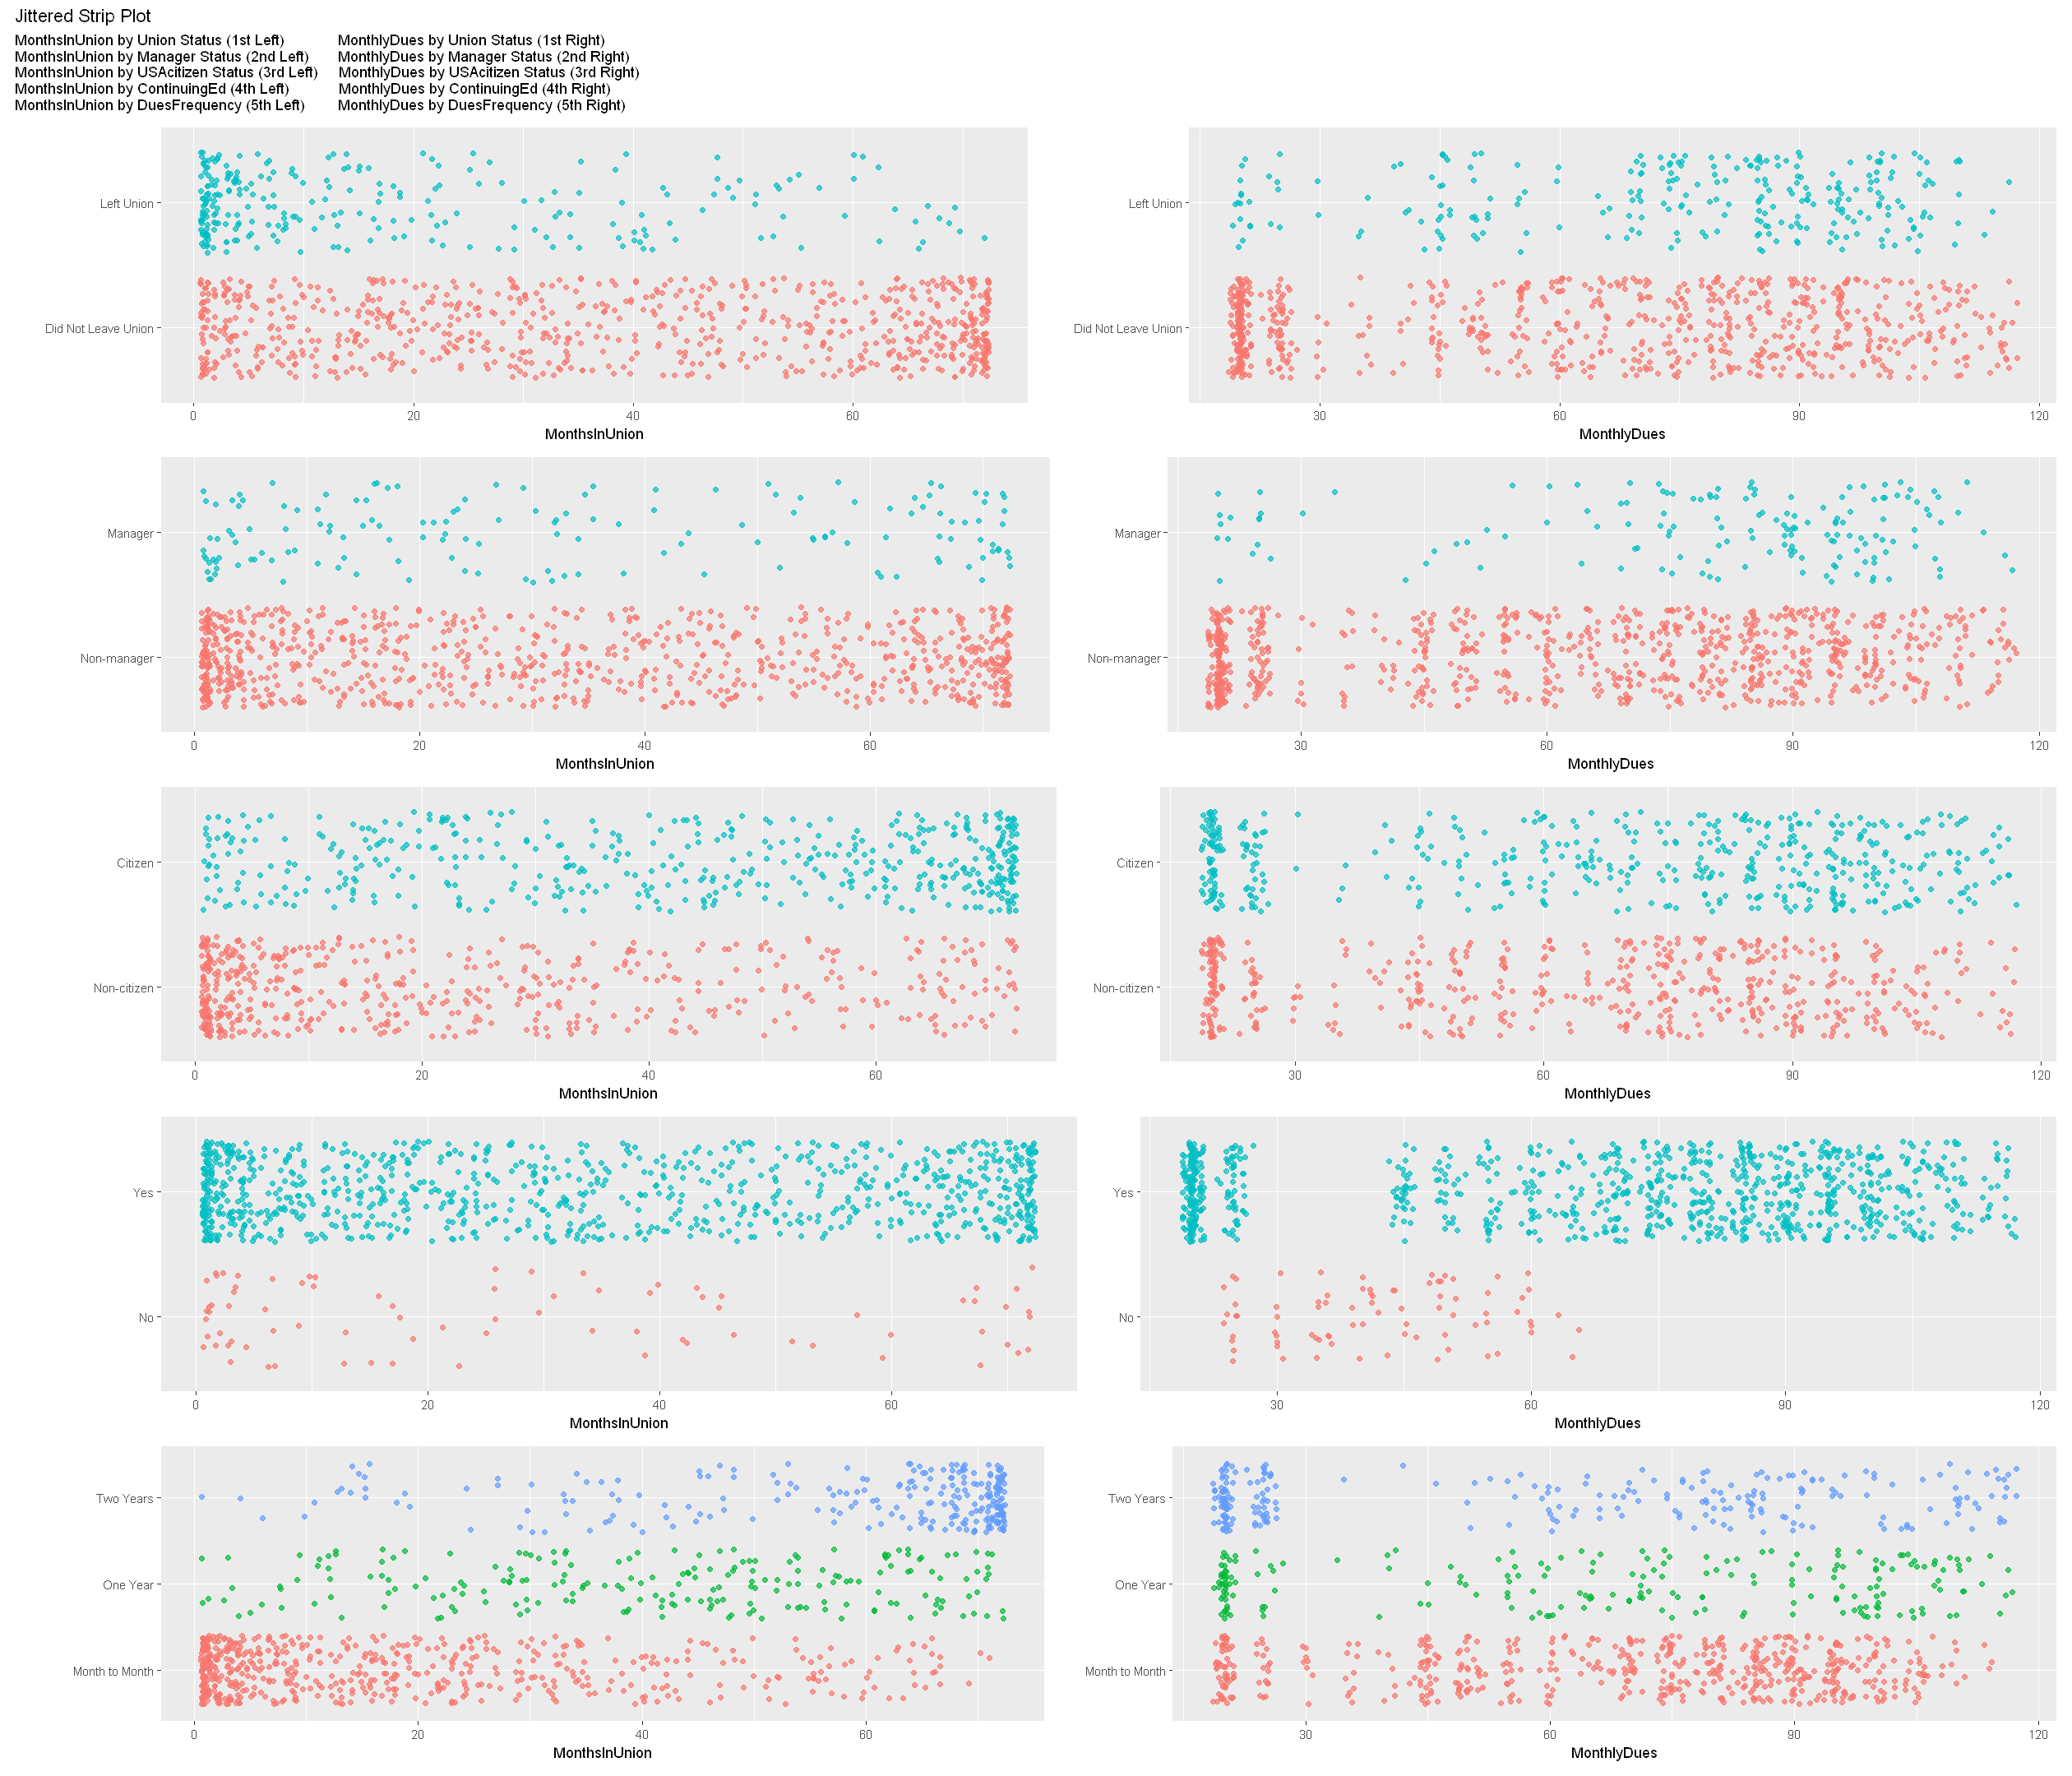

In [13]:
# Jittered Strip Plot
options(repr.plot.width=21, repr.plot.height=18)
jitter1 <- ggplot(train, aes(y=factor(LeftUnion, labels=c('Did Not Leave Union','Left Union')), x=MonthsInUnion, color=LeftUnion)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')
jitter2 <- ggplot(train, aes(y=factor(LeftUnion, labels=c('Did Not Leave Union','Left Union')), x=MonthlyDues, color=LeftUnion)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')

jitter3 <- ggplot(train, aes(y=factor(Management, labels=c('Non-manager', 'Manager')), x=MonthsInUnion, color=Management)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')
jitter4 <- ggplot(train, aes(y=factor(Management, labels=c('Non-manager', 'Manager')), x=MonthlyDues, color=Management)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')

jitter5 <- ggplot(train, aes(y=factor(USAcitizen, labels=c('Non-citizen', 'Citizen')), x=MonthsInUnion, color=USAcitizen)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')
jitter6 <- ggplot(train, aes(y=factor(USAcitizen, labels=c('Non-citizen', 'Citizen')), x=MonthlyDues, color=USAcitizen)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')

jitter7 <- ggplot(train, aes(y=factor(ContinuingEd, labels=c('No', 'Yes')), x=MonthsInUnion, color=ContinuingEd)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')
jitter8 <- ggplot(train, aes(y=factor(ContinuingEd, labels=c('No', 'Yes')), x=MonthlyDues, color=ContinuingEd)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')

jitter9 <- ggplot(train, aes(y=factor(DuesFrequency, labels=c('Month to Month', 'One Year', 'Two Years')), x=MonthsInUnion, color=DuesFrequency)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')
jitter10 <- ggplot(train, aes(y=factor(DuesFrequency, labels=c('Month to Month', 'One Year', 'Two Years')), x=MonthlyDues, color=DuesFrequency)) + geom_jitter(alpha=.7,size=1.5) + theme(legend.position = "none") + labs(y='')

patchwork5 <- (jitter1 + jitter2)/(jitter3 + jitter4)/(jitter5 + jitter6)/(jitter7 + jitter8)/(jitter9 + jitter10)
patchwork5 + plot_annotation(title='Jittered Strip Plot',subtitle= 'MonthsInUnion by Union Status (1st Left)             MonthlyDues by Union Status (1st Right)
MonthsInUnion by Manager Status (2nd Left)       MonthlyDues by Manager Status (2nd Right)
MonthsInUnion by USAcitizen Status (3rd Left)     MonthlyDues by USAcitizen Status (3rd Right)
MonthsInUnion by ContinuingEd (4th Left)            MonthlyDues by ContinuingEd (4th Right)
MonthsInUnion by DuesFrequency (5th Left)        MonthlyDues by DuesFrequency (5th Right)')

##### The jittered strip plots confirm the conclusions I drew from the scatterplots. The top 2 graphs show individuals who leave the union are more likely to be short-term members and have higher monthly dues. The distribution of members who did not leave the union is more even, but there is a concentration of points around high MonthsInUnion and low MonthlyDues, showing members are more likely to remain if they have been long-time members and have low month dues. The next 2 graphs show managers have higher monthly dues and non-manager dues are more spread out, with a concentration of non-managers having low monthly dues. The third pair of graphs reveals USA citizens are more likely to be long-term members and non-citizens are more likely to be short-term members. Both citizens and non-citizens have a concentration of points around low MonthlyDues, showing the data is skewed to the left for both groups. I cross-reference summary statistics and find that MonthlyDues has a median of 73, but a mean of 66.12, confirming the data is skewed to the left.  

##### The 4th pair of plots shows that individuals who have no continuing education through the union pay low dues. Note, there is a concentration of individuals who receive continuing education and pay low dues. Finally, the last pair of plots confirm my findings from the scatterplots: newer members tend to be on a month to month payment schedule and long-term members tend to be on a two years payment schedule. 

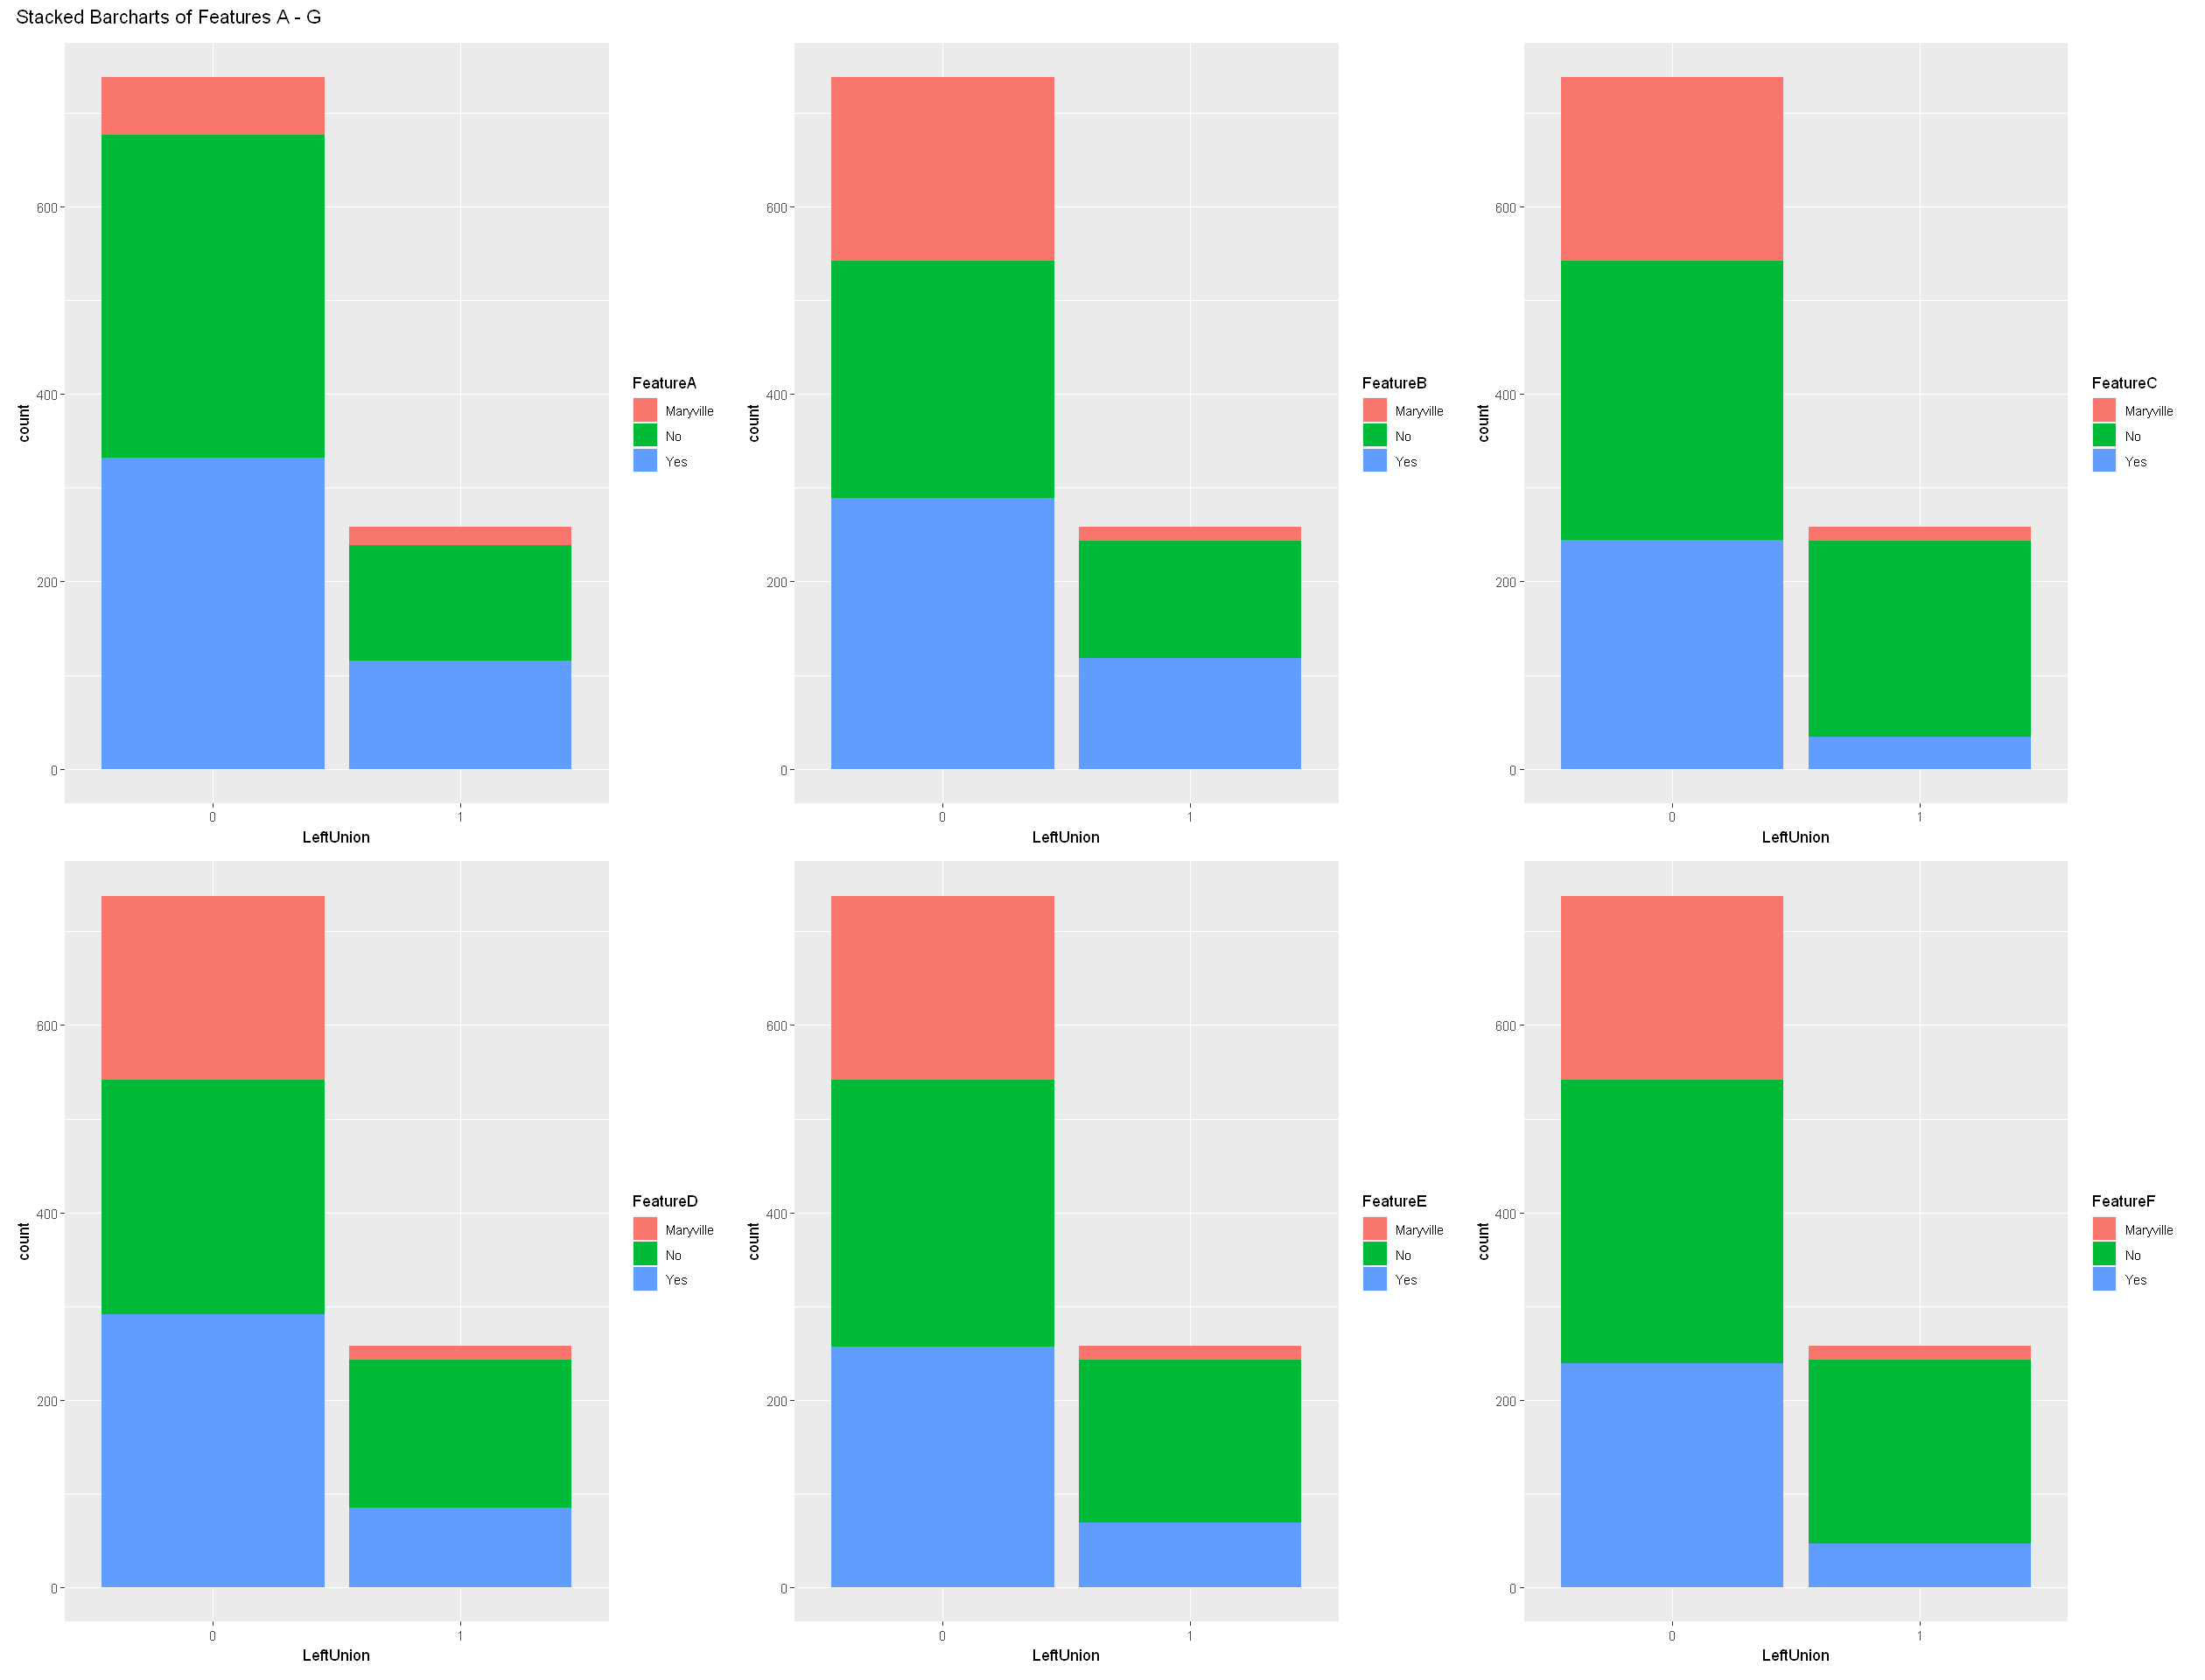

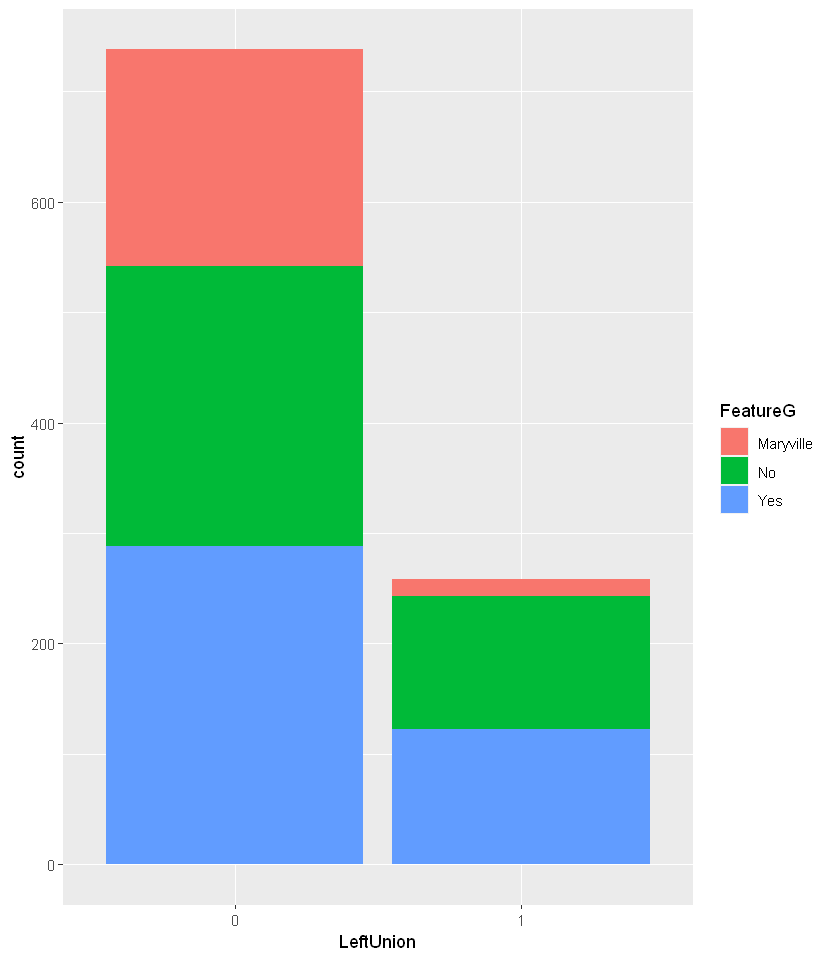

In [14]:
# Stacked bar charts
options(repr.plot.width=21, repr.plot.height=16)
barplot1 <- ggplot(train, aes(x = LeftUnion, fill = FeatureA)) + geom_bar(position = 'stack')
barplot2 <- ggplot(train, aes(x = LeftUnion, fill = FeatureB)) + geom_bar(position = 'stack')
barplot3 <- ggplot(train, aes(x = LeftUnion, fill = FeatureC)) + geom_bar(position = 'stack')
barplot4 <- ggplot(train, aes(x = LeftUnion, fill = FeatureD)) + geom_bar(position = 'stack')
barplot5 <- ggplot(train, aes(x = LeftUnion, fill = FeatureE)) + geom_bar(position = 'stack')
barplot6 <- ggplot(train, aes(x = LeftUnion, fill = FeatureF)) + geom_bar(position = 'stack')
barplot7 <- ggplot(train, aes(x = LeftUnion, fill = FeatureG)) + geom_bar(position = 'stack') 
patchwork6 <- (barplot1+barplot2+barplot3)/(barplot4+barplot5+barplot6)
patchwork6 + plot_annotation(title='Stacked Barcharts of Features A - G')
options(repr.plot.width=7, repr.plot.height=8)
barplot7

##### The barcharts above show the distributions of Features A to G between LeftUnion status. From looking at the charts, it appears Maryville is the least frequent feature. Features C through F display a majority No among people who left the union. I will check the counts of Maryville, No, and Yes among all the features below. Without knowing what these features represent, it is difficult to draw any more conclusions. 

In [15]:
table(train['FeatureA'])+ table(train['FeatureB'])+ table(train['FeatureC'])+ table(train['FeatureD'])+ table(train['FeatureE'])+ table(train['FeatureF'])+ table(train['FeatureG'])

FeatureA
Maryville        No       Yes 
     1346      3096      2530 

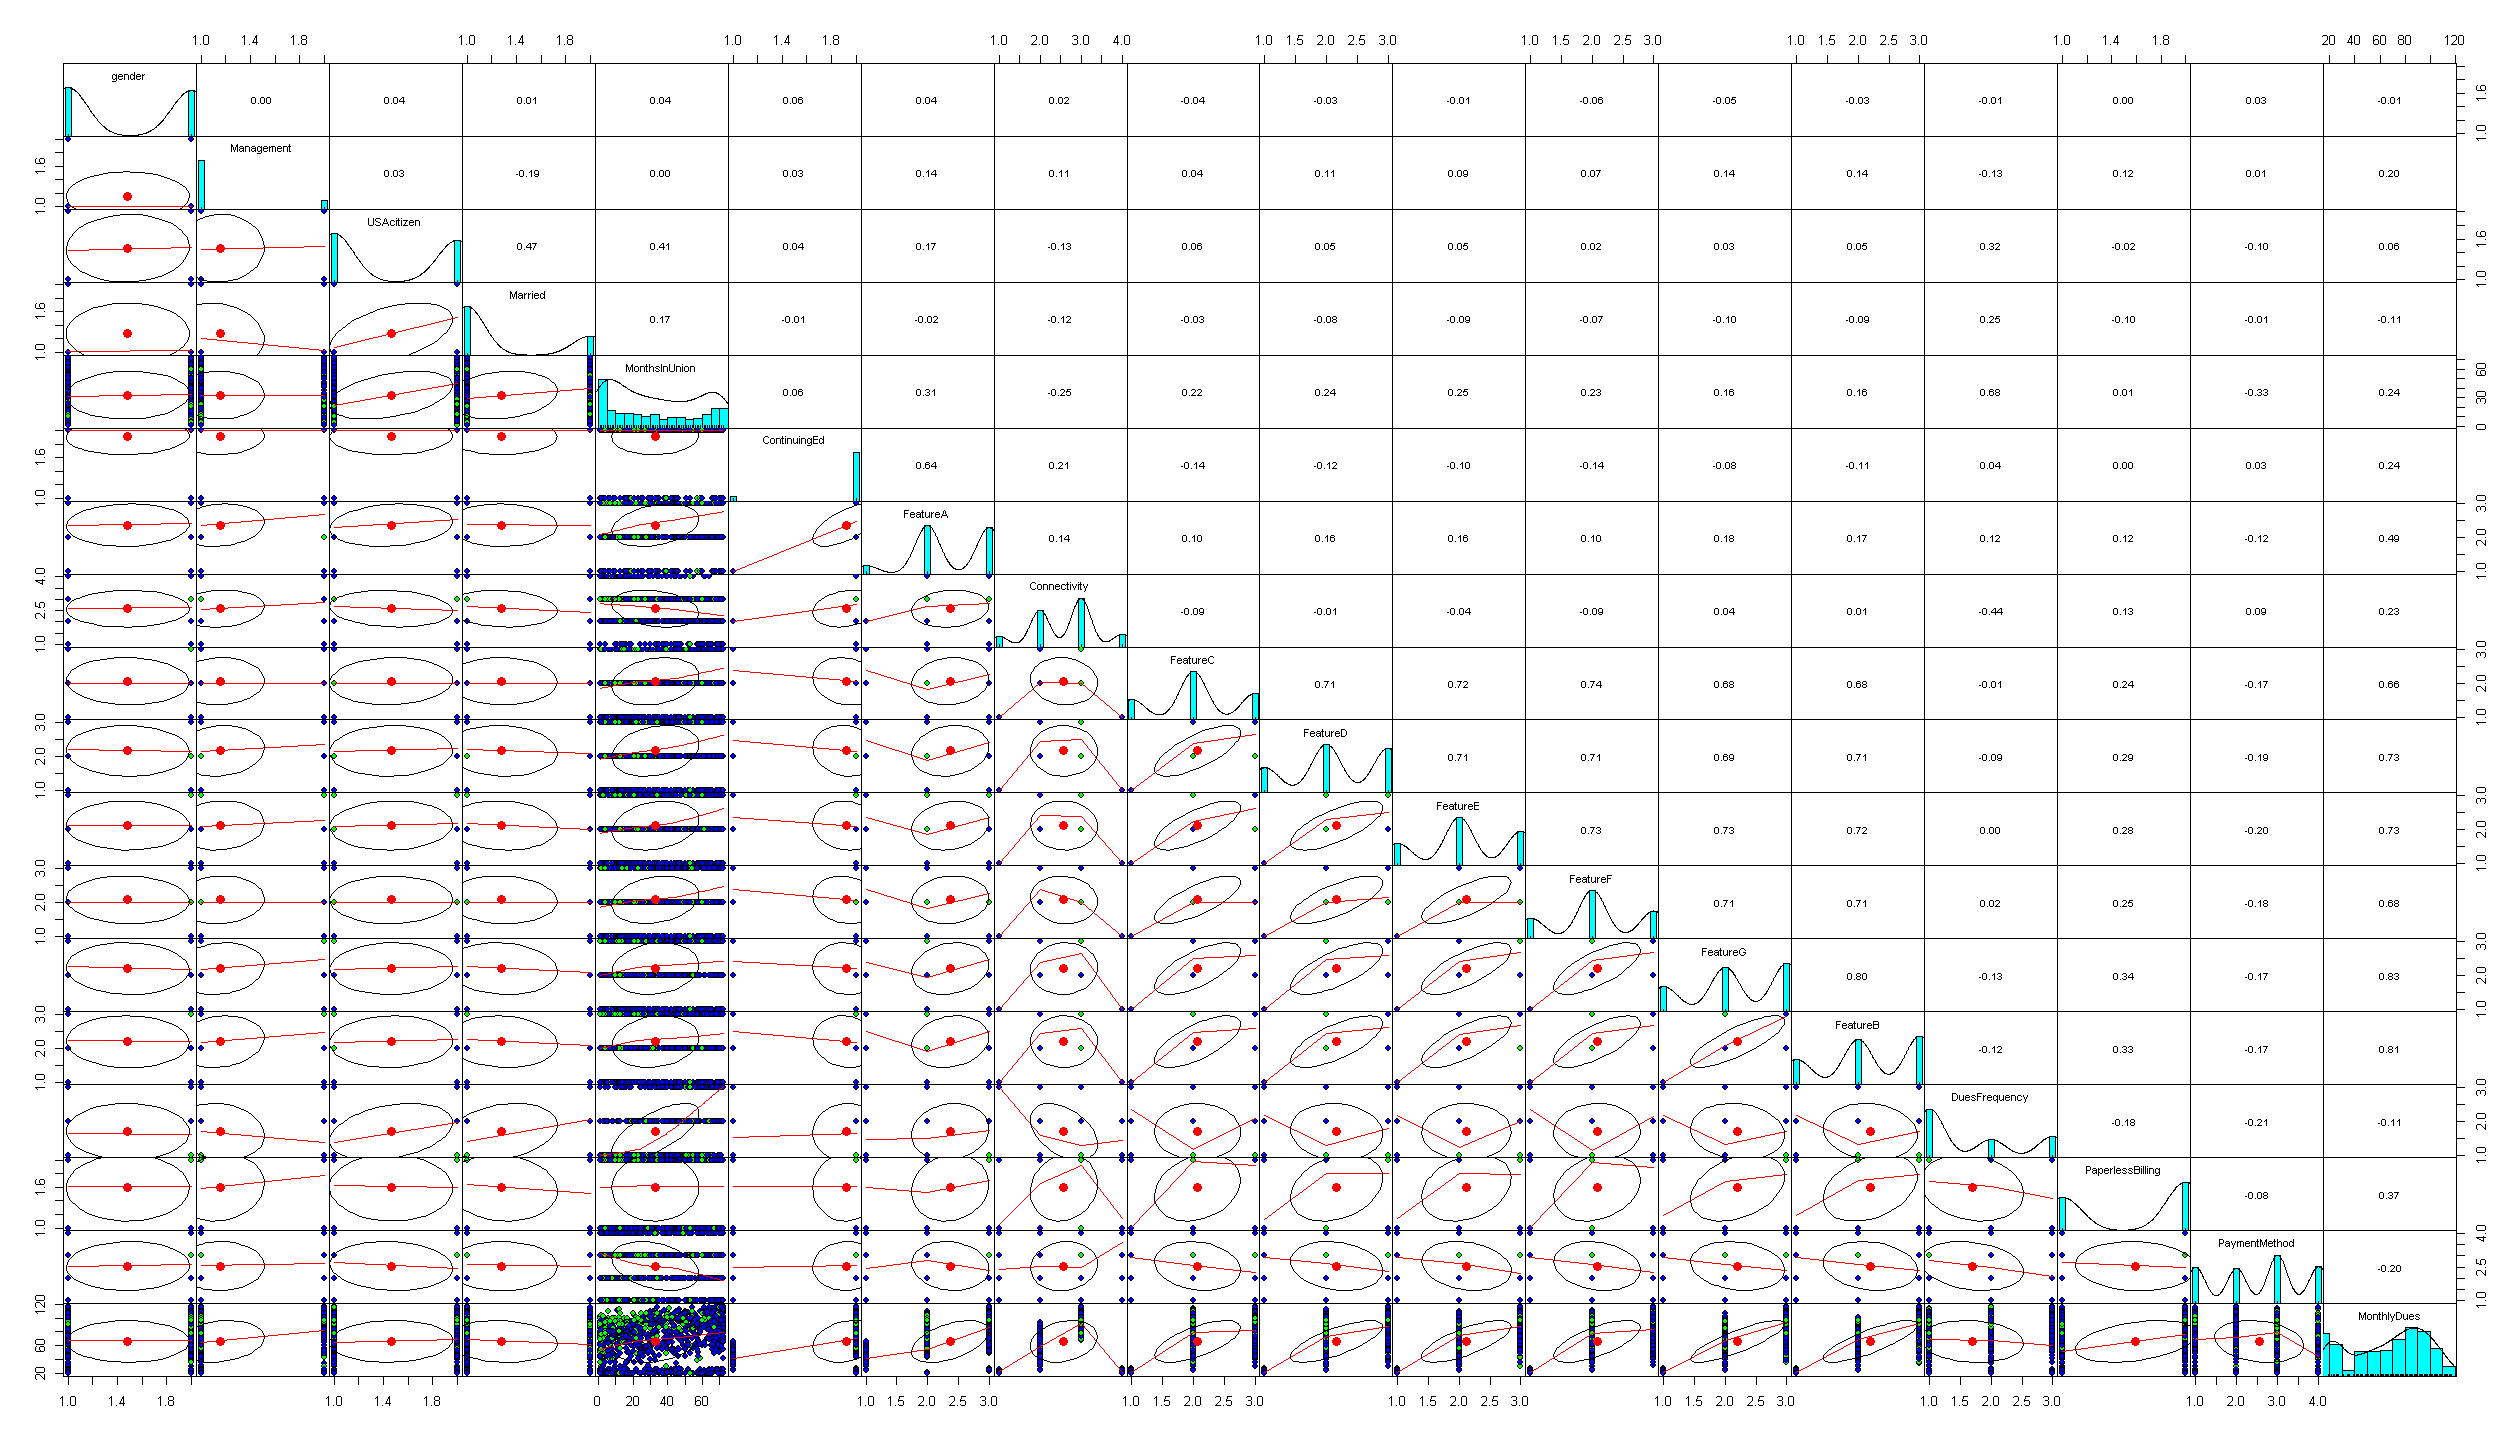

In [16]:
# Pairs panel of original features
options(repr.plot.width=21, repr.plot.height=12)
pairs.panels(train[,-ncol(train)],gap=0, bg=c('blue', 'green', 'red')[train$LeftUnion], pch=21)

##### Note that many of the variables are correlated with each other as indicated by the correlation values in the graph. I will address the issue of multicollinearity in the next section using principal component analysis. 

### Part 3: Principal Component Analysis (PCA)
##### The basic principle behind PCA is to find eigenvectors, which are vectors along the axis of greatest variance in the dataset. PCA transforms features into principal components, with PC1 explaining the most variance, PC2 the second most and so forth. As PCA is essentially a variance calculation, outliers are highly influential, which is why I removed them earlier. PCA also solves the issue of multicollinearity as all eigenvectors are orthogonal to the primary or previous axis line, which means the principal components exhibit no collinearity. 
##### I first transform all categorical features into dummies via one hot encoding, before splitting the train set into training and validation sets and conducting PCA. 

In [17]:
# Temporarily convert LeftUnion to numeric so the column does not get split
train$LeftUnion <- as.numeric(train$LeftUnion)
# Transform all factors into dummy variables
dummy <- dummyVars('~.', data=train)
train_dummy <- data.frame(predict(dummy,newdata=train))
# After doing the transformation, LeftUnion column had 1 added to every value, so I will convert the column back. 
train_dummy$LeftUnion <- factor(train_dummy$LeftUnion - 1)
head(train_dummy)

,gender.Female,gender.Male,Management.0,Management.1,USAcitizen.No,USAcitizen.Yes,Married.No,Married.Yes,MonthsInUnion,ContinuingEd.No,⋯,DuesFrequency.One.year,DuesFrequency.Two.year,PaperlessBilling.No,PaperlessBilling.Yes,PaymentMethod.Bank.transfer..automatic.,PaymentMethod.Credit.card..automatic.,PaymentMethod.Electronic.check,PaymentMethod.Mailed.check,MonthlyDues,LeftUnion
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,0,1,1,0,1,0,1,0,18,0,⋯,1,0,0,1,0,1,0,0,90,0
2,0,1,1,0,0,1,0,1,47,0,⋯,0,0,1,0,0,0,1,0,54,0
3,1,0,1,0,0,1,0,1,13,0,⋯,0,1,1,0,0,0,0,1,20,0
4,1,0,1,0,1,0,1,0,56,0,⋯,0,0,0,1,1,0,0,0,105,0
5,0,1,1,0,1,0,1,0,67,0,⋯,0,1,1,0,1,0,0,0,51,0
6,0,1,1,0,1,0,1,0,30,0,⋯,0,1,0,1,0,0,0,1,56,0


In [18]:
# Set random seed for reproducibility
set.seed(1)
# Split train_dummy into train_final and valid_final using an 80:20 split
idx <- sample(seq(1, 2), size = nrow(train_dummy), replace = TRUE, prob = c(.8, .2))
train_final <- train_dummy[idx == 1,]
valid_final <- train_dummy[idx == 2,]

In [19]:
# Confirm training data was split correctly in a 80:20 ratio
nrow(train_dummy)
nrow(train_final)
nrow(valid_final)

[1] 996

[1] 798

[1] 198

##### I create the PCA model using train_final. This will eliminate multicollinearity and reduce the number of features to be used.

In [20]:
# By setting center = TRUE and Scale = TRUE, we are able to normalize our data to have unit variance and centered around the mean
pca <- prcomp(train_final[,-ncol(train_final)], center = TRUE, scale = TRUE)
attributes(pca)

$names
[1] "sdev"     "rotation" "center"   "scale"    "x"       

$class
[1] "prcomp"

In [21]:
# Quick check to see if the center equals the mean
pca$center
mean(train_final$MonthlyDues)

gender.Female                             gender.Male 
                             0.52380952                              0.47619048 
                           Management.0                            Management.1 
                             0.84837093                              0.15162907 
                          USAcitizen.No                          USAcitizen.Yes 
                             0.53383459                              0.46616541 
                             Married.No                             Married.Yes 
                             0.71177945                              0.28822055 
                          MonthsInUnion                         ContinuingEd.No 
                            32.94235589                              0.07894737 
                       ContinuingEd.Yes                      FeatureA.Maryville 
                             0.92105263                              0.07894737 
                            FeatureA.No                            FeatureA.Yes 
                             0.48120301                              0.43984962 
                   Connectivity.Dial.in                        Connectivity.DSL 
                             0.09398496                              0.34335840 
               Connectivity.Fiber.optic                  Connectivity.onlyViaER 
                             0.44486216                              0.11779449 
                     FeatureC.Maryville                             FeatureC.No 
                             0.21177945                              0.50250627 
                           FeatureC.Yes                      FeatureD.Maryville 
                             0.28571429                              0.21177945 
                            FeatureD.No                            FeatureD.Yes 
                             0.41353383                              0.37468672 
                     FeatureE.Maryville                             FeatureE.No 
                             0.21177945                              0.45363409 
                           FeatureE.Yes                      FeatureF.Maryville 
                             0.33458647                              0.21177945 
                            FeatureF.No                            FeatureF.Yes 
                             0.49122807                              0.29699248 
                     FeatureG.Maryville                             FeatureG.No 
                             0.21177945                              0.37844612 
                           FeatureG.Yes                      FeatureB.Maryville 
                             0.40977444                              0.21177945 
                            FeatureB.No                            FeatureB.Yes 
                             0.38847118                              0.39974937 
           DuesFrequency.Month.to.month                  DuesFrequency.One.year 
                             0.54385965                              0.21553885 
                 DuesFrequency.Two.year                     PaperlessBilling.No 
                             0.24060150                              0.41228070 
                   PaperlessBilling.Yes PaymentMethod.Bank.transfer..automatic. 
                             0.58771930                              0.22681704 
  PaymentMethod.Credit.card..automatic.          PaymentMethod.Electronic.check 
                             0.22807018                              0.31704261 
             PaymentMethod.Mailed.check                             MonthlyDues 
                             0.22807018                             65.98120301

[1] 65.9812

In [22]:
# Quick check to see if the scale equals the standard deviation
pca$scale
sd(train_final$MonthlyDues)

gender.Female                             gender.Male 
                              0.4997460                               0.4997460 
                           Management.0                            Management.1 
                              0.3588859                               0.3588859 
                          USAcitizen.No                          USAcitizen.Yes 
                              0.4991668                               0.4991668 
                             Married.No                             Married.Yes 
                              0.4532183                               0.4532183 
                          MonthsInUnion                         ContinuingEd.No 
                             25.1655335                               0.2698257 
                       ContinuingEd.Yes                      FeatureA.Maryville 
                              0.2698257                               0.2698257 
                            FeatureA.No                            FeatureA.Yes 
                              0.4999599                               0.4966800 
                   Connectivity.Dial.in                        Connectivity.DSL 
                              0.2919908                               0.4751277 
               Connectivity.Fiber.optic                  Connectivity.onlyViaER 
                              0.4972622                               0.3225668 
                     FeatureC.Maryville                             FeatureC.No 
                              0.4088256                               0.5003073 
                           FeatureC.Yes                      FeatureD.Maryville 
                              0.4520373                               0.4088256 
                            FeatureD.No                            FeatureD.Yes 
                              0.4927757                               0.4843455 
                     FeatureE.Maryville                             FeatureE.No 
                              0.4088256                               0.4981578 
                           FeatureE.Yes                      FeatureF.Maryville 
                              0.4721416                               0.4088256 
                            FeatureF.No                            FeatureF.Yes 
                              0.5002366                               0.4572198 
                     FeatureG.Maryville                             FeatureG.No 
                              0.4088256                               0.4853038 
                           FeatureG.Yes                      FeatureB.Maryville 
                              0.4921004                               0.4088256 
                            FeatureB.No                            FeatureB.Yes 
                              0.4877083                               0.4901539 
           DuesFrequency.Month.to.month                  DuesFrequency.One.year 
                              0.4983850                               0.4114535 
                 DuesFrequency.Two.year                     PaperlessBilling.No 
                              0.4277168                               0.4925539 
                   PaperlessBilling.Yes PaymentMethod.Bank.transfer..automatic. 
                              0.4925539                               0.4190359 
  PaymentMethod.Credit.card..automatic.          PaymentMethod.Electronic.check 
                              0.4198512                               0.4656160 
             PaymentMethod.Mailed.check                             MonthlyDues 
                              0.4198512                              30.1659716

[1] 30.16597

In [23]:
summary(pca)

Importance of components:
                          PC1    PC2     PC3    PC4     PC5     PC6    PC7
Standard deviation     3.3457 2.3443 2.02432 1.6021 1.55375 1.42553 1.3965
Proportion of Variance 0.2433 0.1195 0.08908 0.0558 0.05248 0.04418 0.0424
Cumulative Proportion  0.2433 0.3628 0.45190 0.5077 0.56018 0.60435 0.6468
                           PC8     PC9   PC10    PC11    PC12    PC13    PC14
Standard deviation     1.30099 1.27700 1.2450 1.16965 1.13584 1.09104 1.06530
Proportion of Variance 0.03679 0.03545 0.0337 0.02974 0.02805 0.02588 0.02467
Cumulative Proportion  0.68355 0.71900 0.7527 0.78244 0.81048 0.83636 0.86103
                         PC15   PC16   PC17    PC18    PC19    PC20    PC21
Standard deviation     1.0419 1.0287 1.0151 0.96462 0.95156 0.87324 0.59644
Proportion of Variance 0.0236 0.0230 0.0224 0.02023 0.01968 0.01658 0.00773
Cumulative Proportion  0.8846 0.9076 0.9300 0.95026 0.96995 0.98652 0.99426
                          PC22    PC23      PC24      PC25

##### Note that 100% of the variance is explained by the first 23 principal components. Next, I will generate scree plots of the principal components and a pairs plot of the principal components I intend to include. 

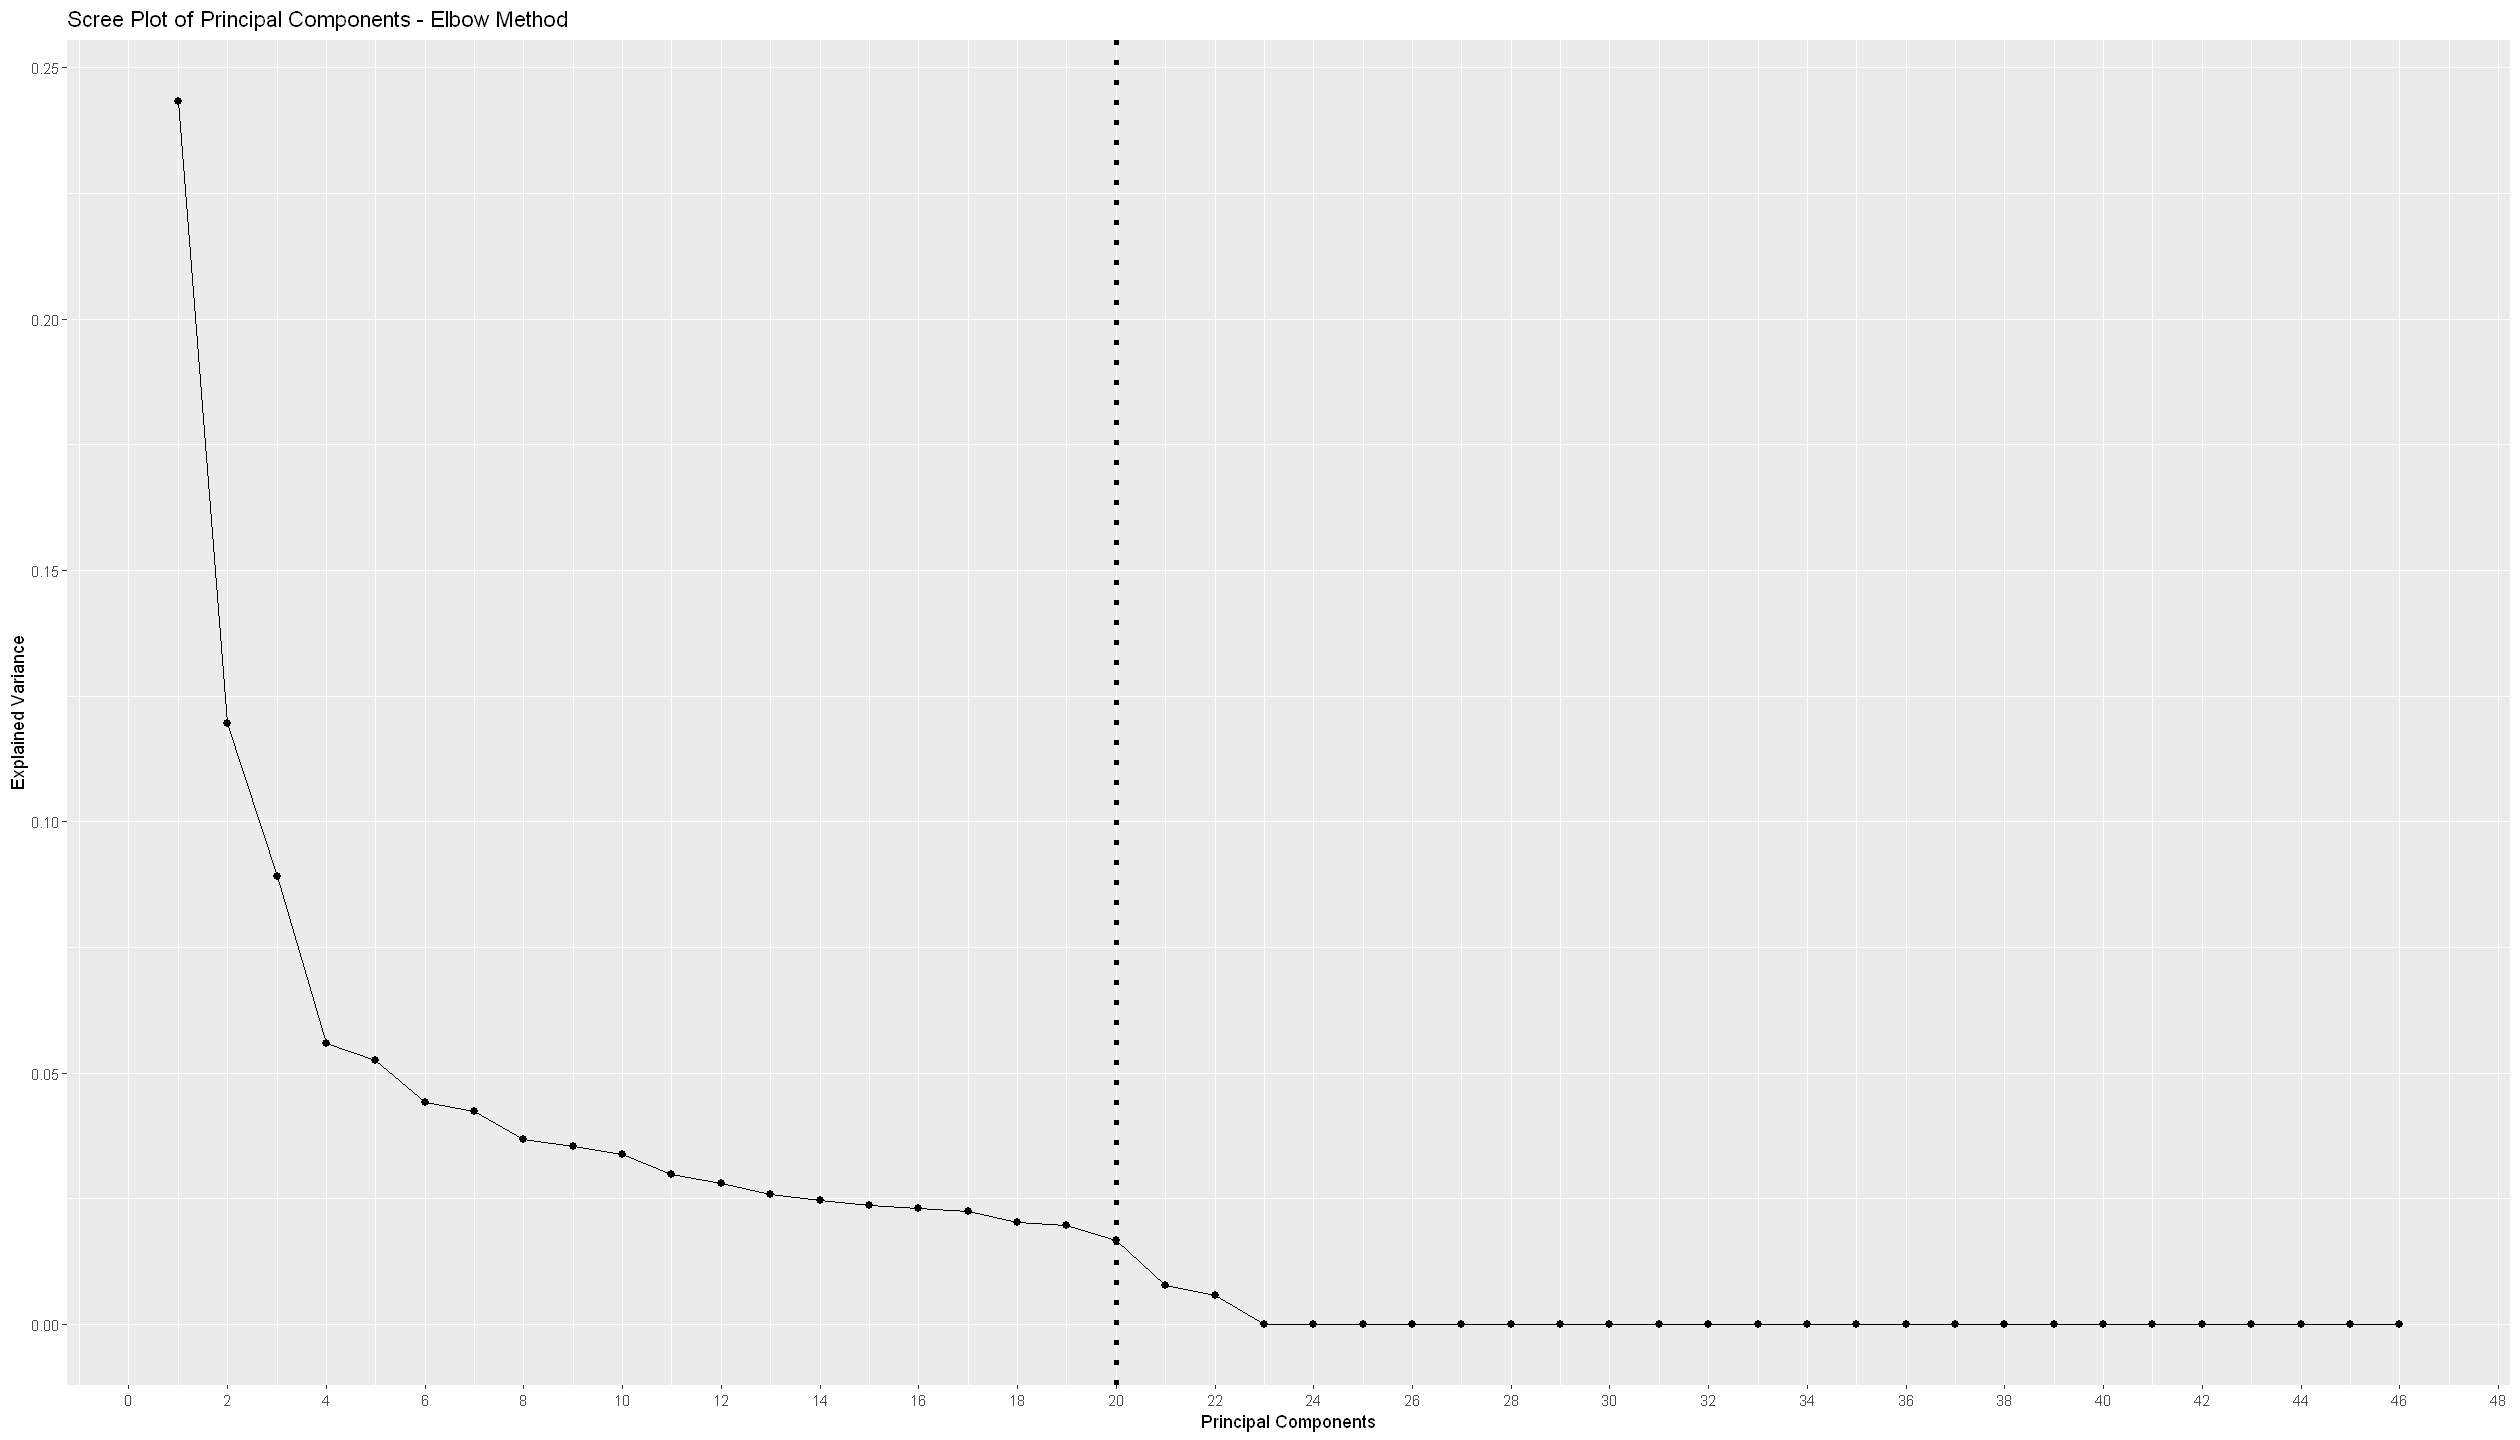

In [24]:
# Scree plot of principal components
temp_df <- data.frame(label = (1:46), var_explained = (pca$sdev)^2 / sum((pca$sdev)^2))
ggplot(temp_df,aes(x=label, y=var_explained)) + geom_point(size=2) + geom_line() + geom_vline(xintercept=20, linetype='dotted', linewidth=1.5) +
ggtitle('Scree Plot of Principal Components - Elbow Method') + xlab('Principal Components') + ylab('Explained Variance') + scale_x_continuous(n.breaks=23)

##### Using the elbow method, I choose the number of components based on the point before the curve flattens out. This would be principal component 20. I will also check using Kaiser's Rule, which is based on keeping components with eigenvalues greater than 1. 

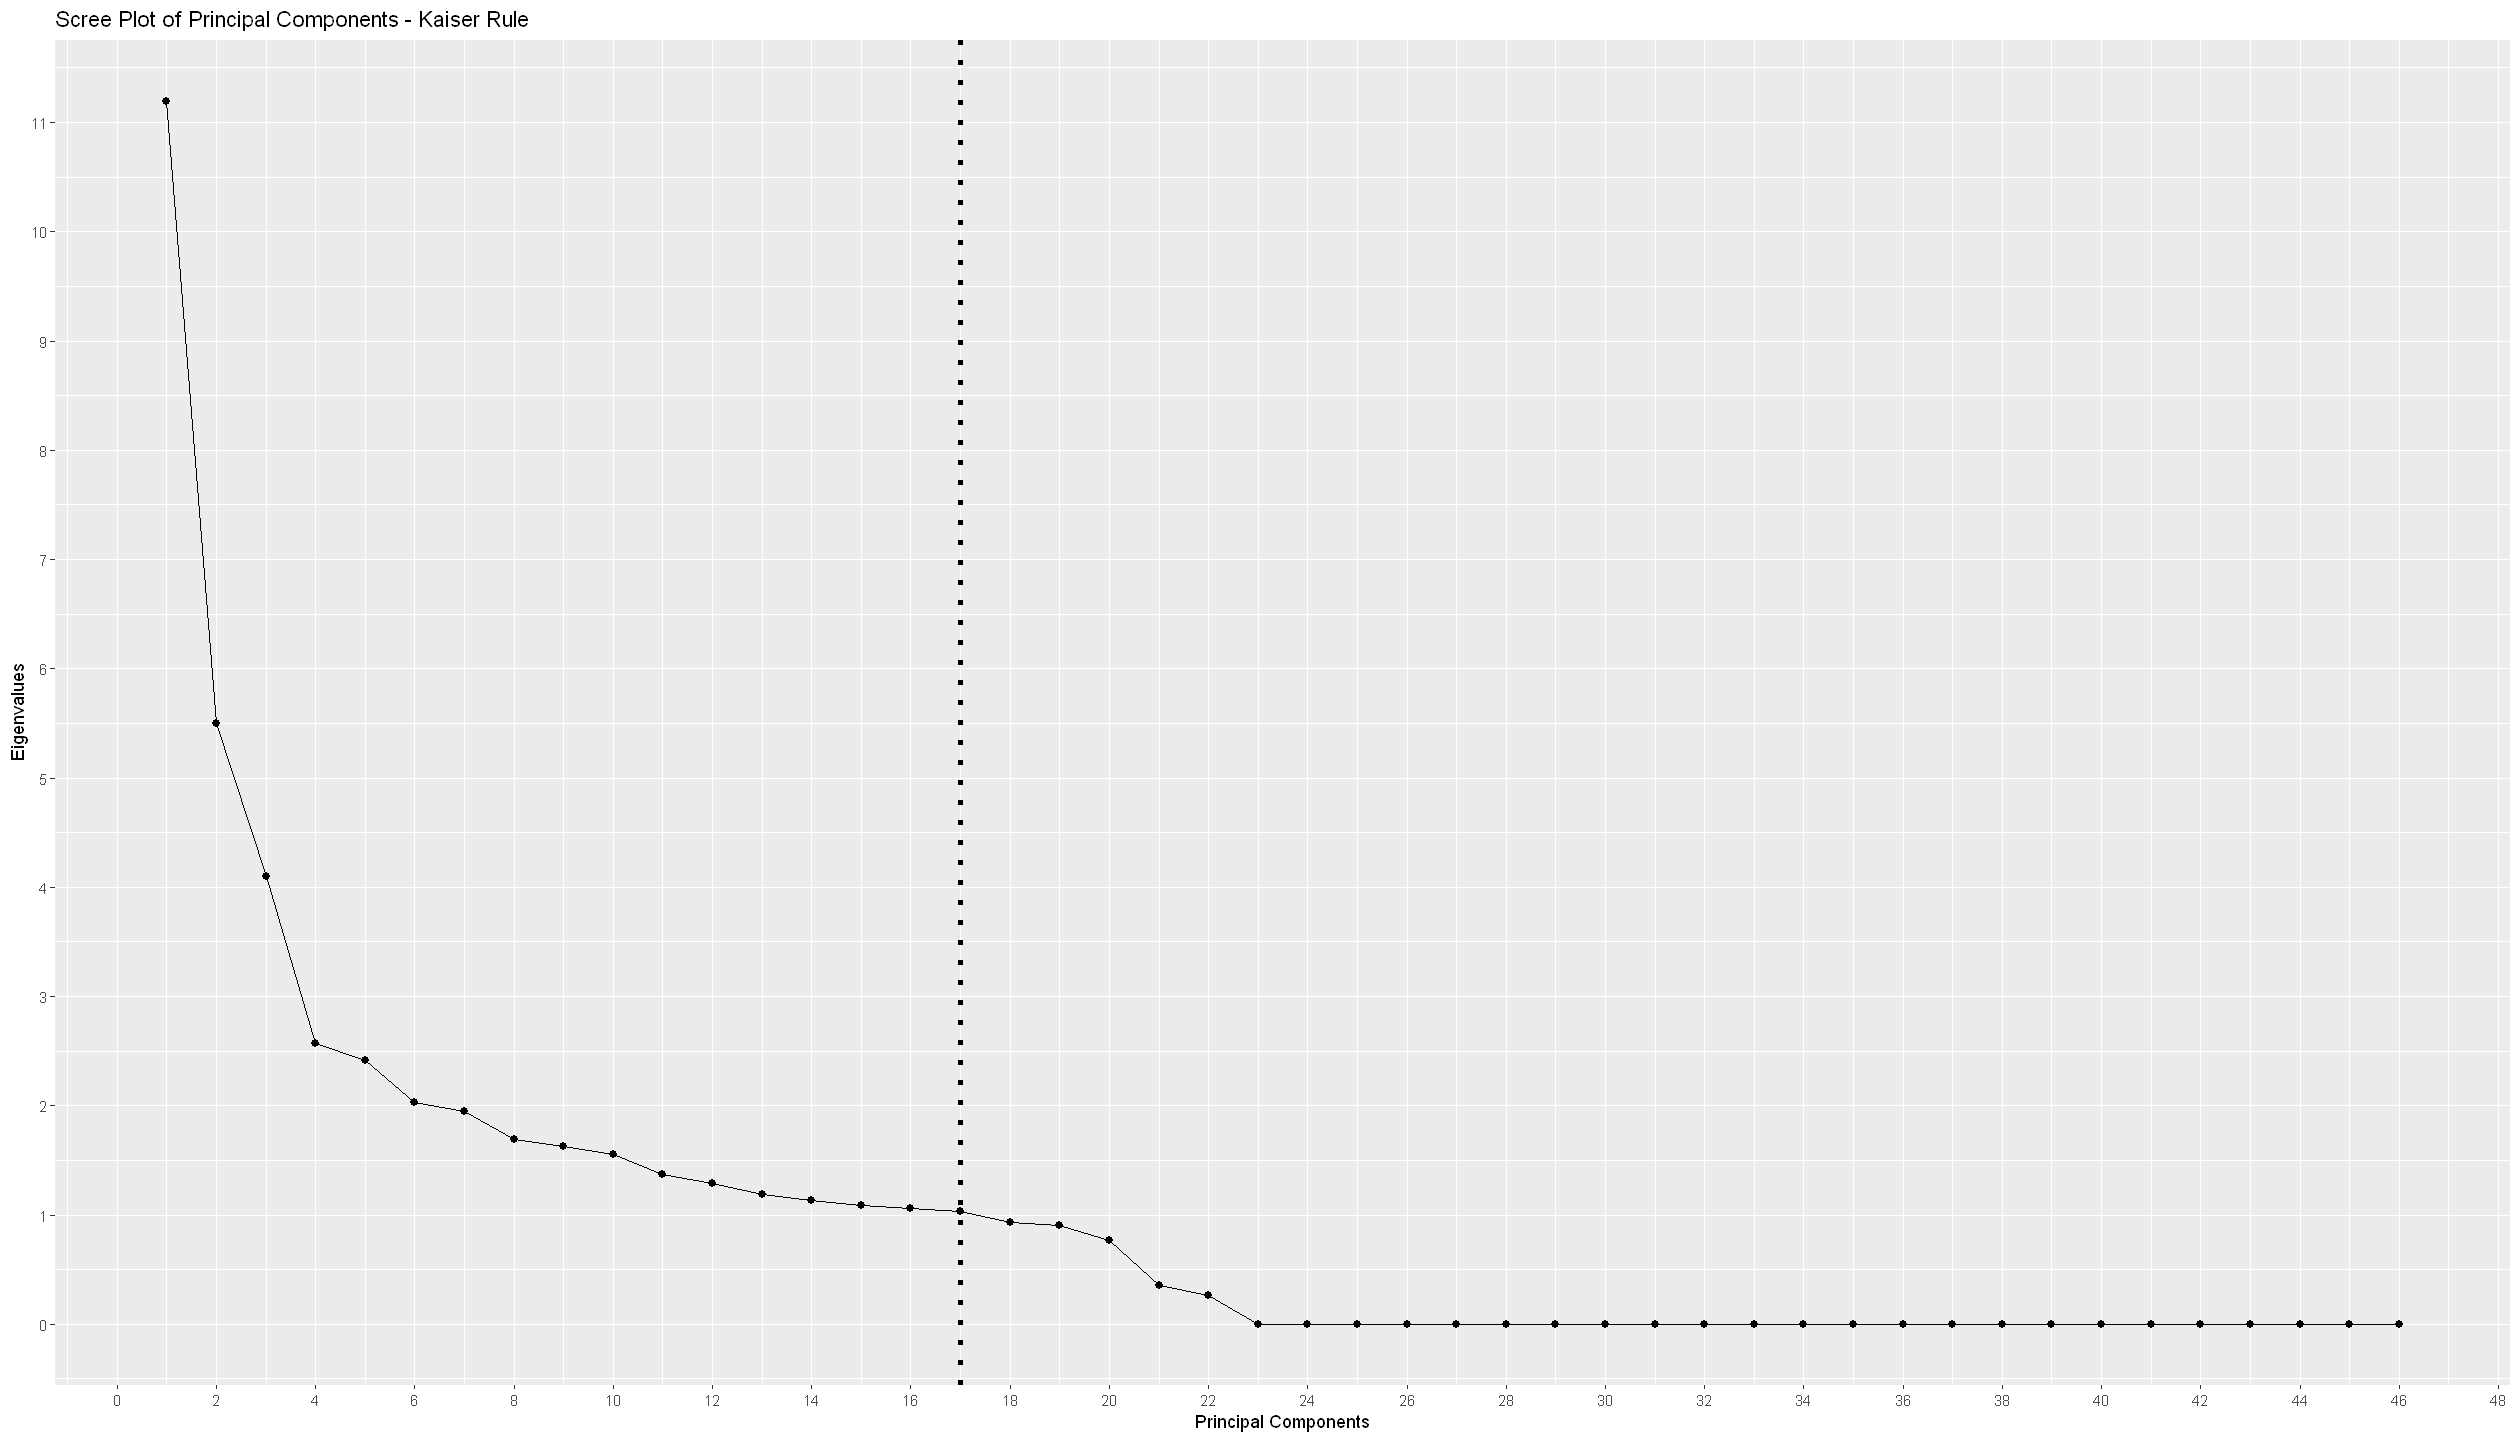

In [25]:
# Scree plot with eigenvalues as y axis
eig.val <- get_eigenvalue(pca)
eig_df <- data.frame(label = (1:46), eigenvalues = as.numeric(unlist(eig.val[1])))
ggplot(eig_df,aes(x=label, y=eigenvalues)) + geom_point(size=2) + geom_line() + geom_vline(xintercept=17, linetype='dotted', linewidth=1.5) +
ggtitle('Scree Plot of Principal Components - Kaiser Rule') + xlab('Principal Components') + ylab('Eigenvalues') + scale_x_continuous(n.breaks=23) + scale_y_continuous(n.breaks=10)

##### From the second scree plot, it appears the last principal component with an eigenvalue greater than 1 is PC17. I check by viewing the first 20 eigenvalues and confirm that PC17 is the last principal component with an eigenvalue greater than 1. Therefore, I will use the first 17 principal components in my models, which explains 93% of the total variance. 

In [26]:
head(eig.val[1],20)

,eigenvalue
,<dbl>
Dim.1,11.1935324
Dim.2,5.4957941
Dim.3,4.0978826
Dim.4,2.5667756
Dim.5,2.4141343
Dim.6,2.0321293
Dim.7,1.9503388
Dim.8,1.6925630
Dim.9,1.6307333


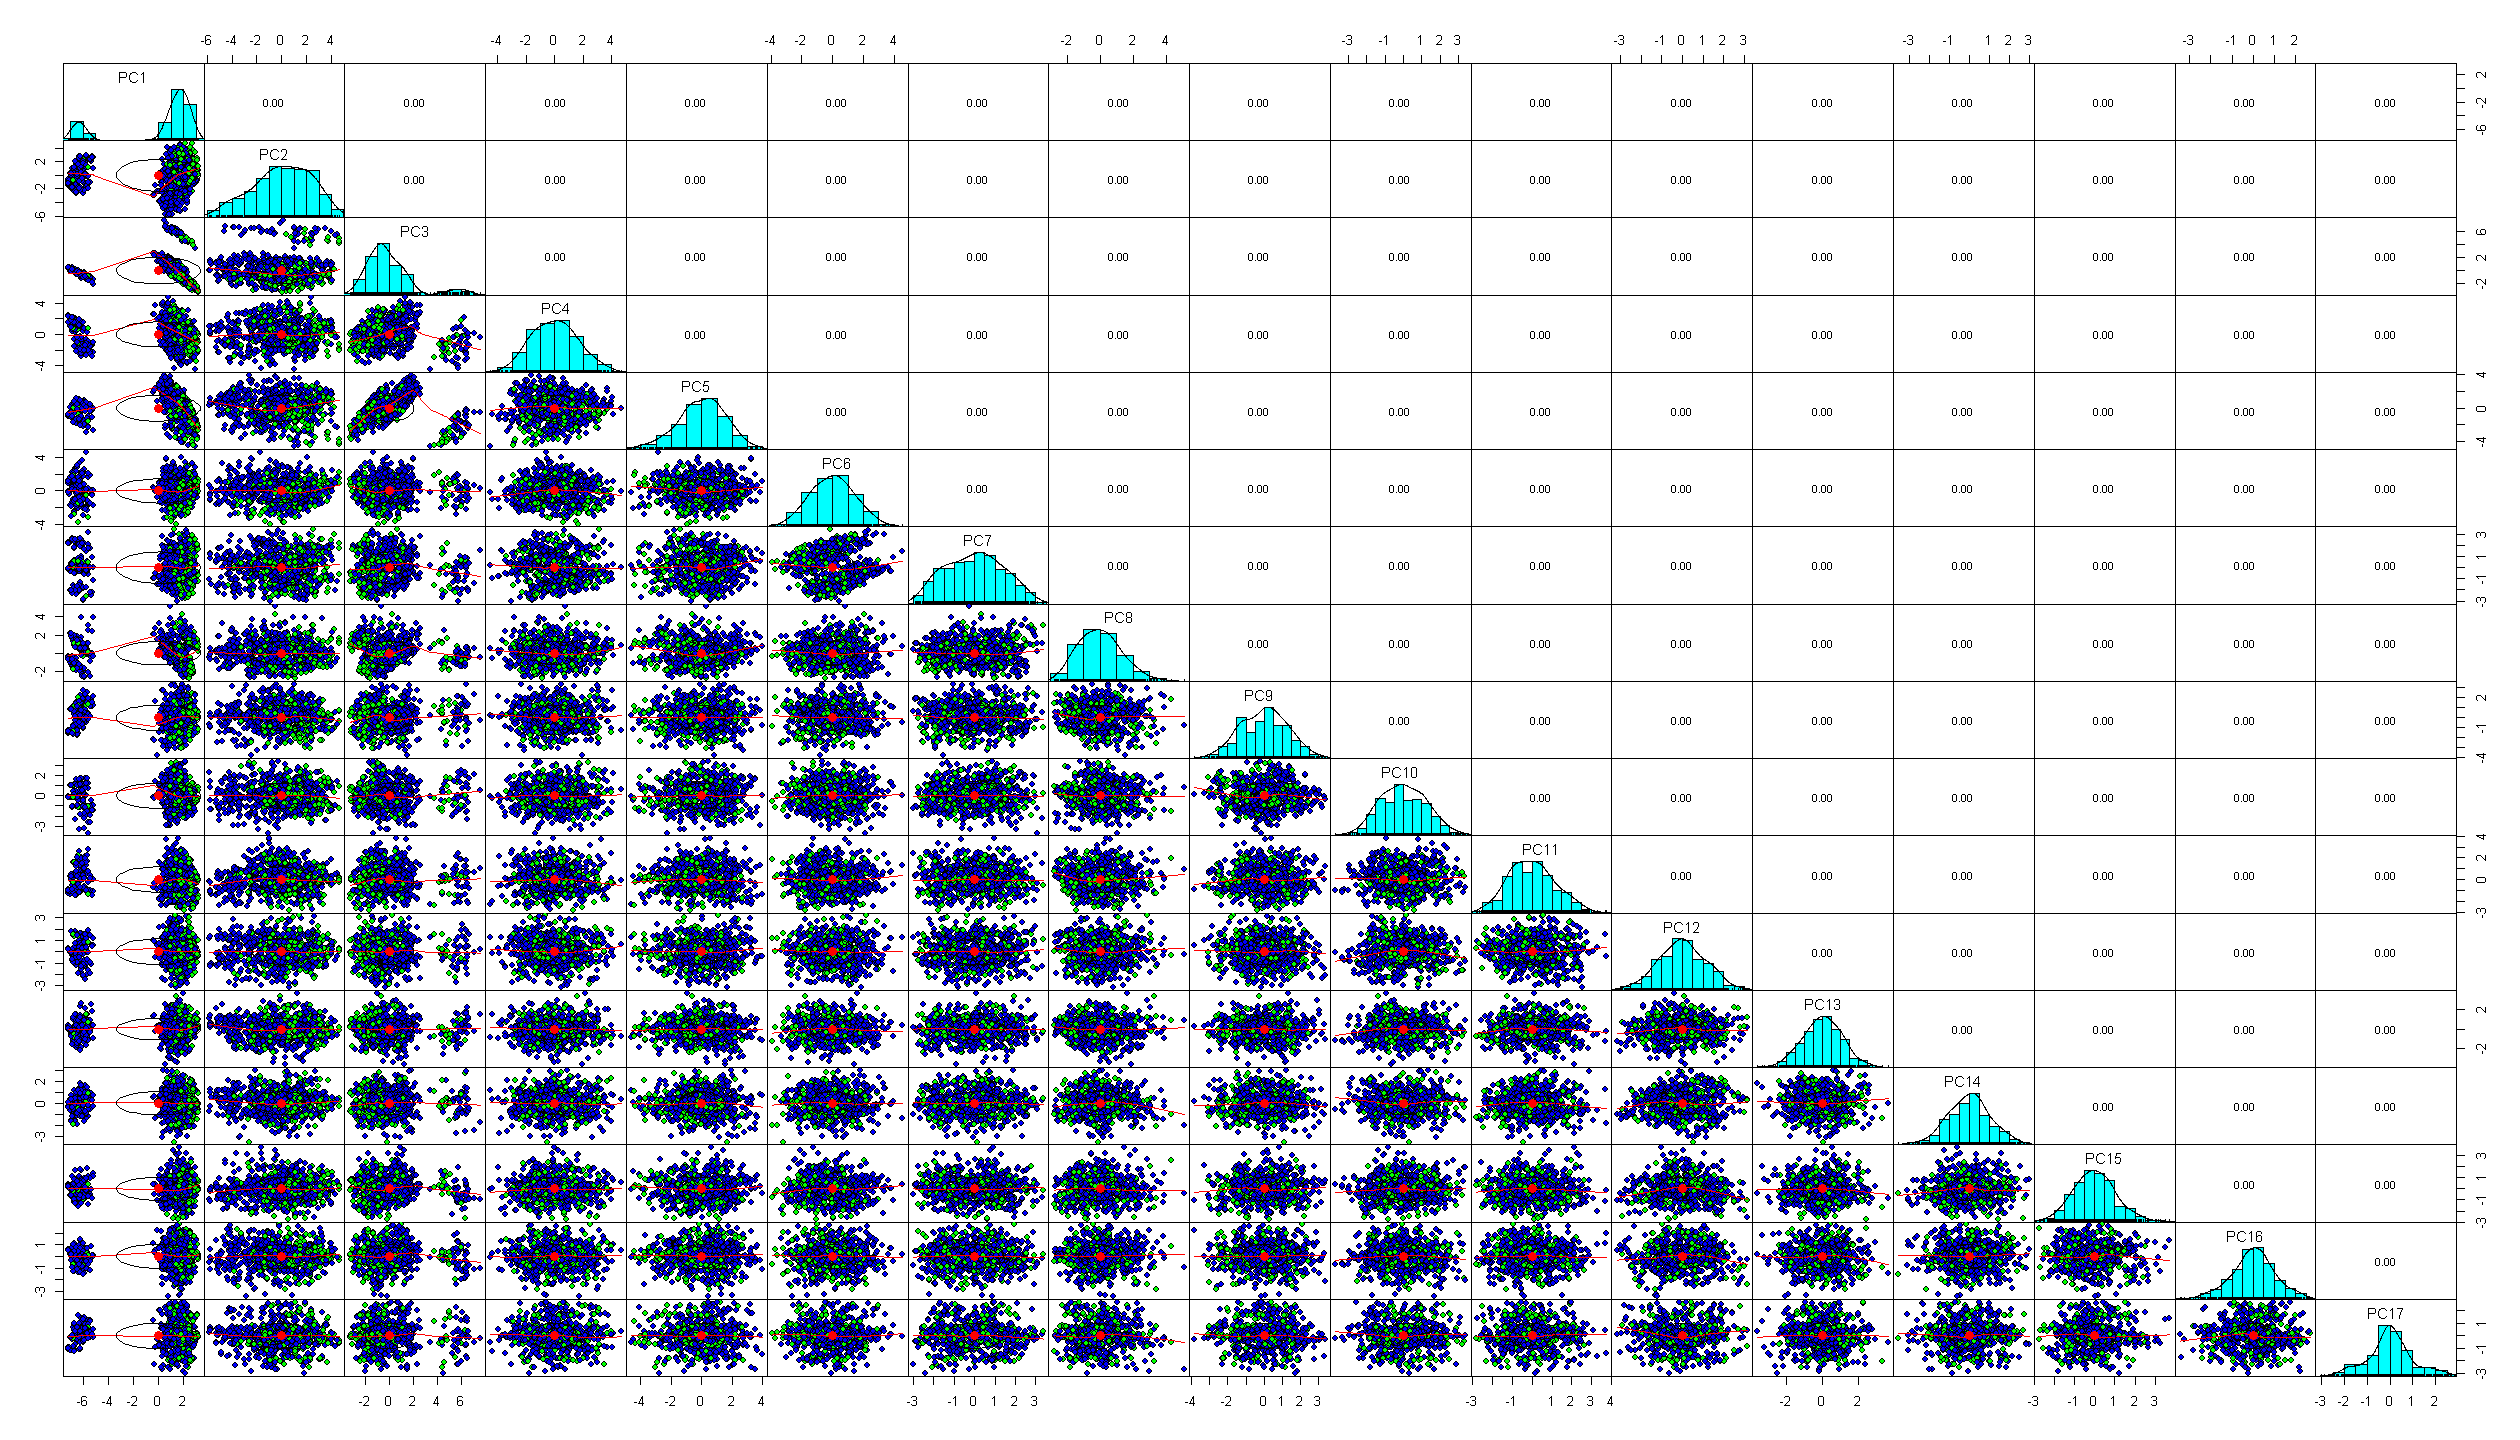

In [27]:
# Pairs panel of the principal components in my PCA model.
pairs.panels(pca$x[,1:17], gap=0, bg=c('blue','green','red')[train_final$LeftUnion],pch=21)

##### Pairs panel of the first 17 principal components confirms any issues of multicollinearity have been resolved as there is no correlation between any of the 17 principal components. Next, I will create PCA biplots. 

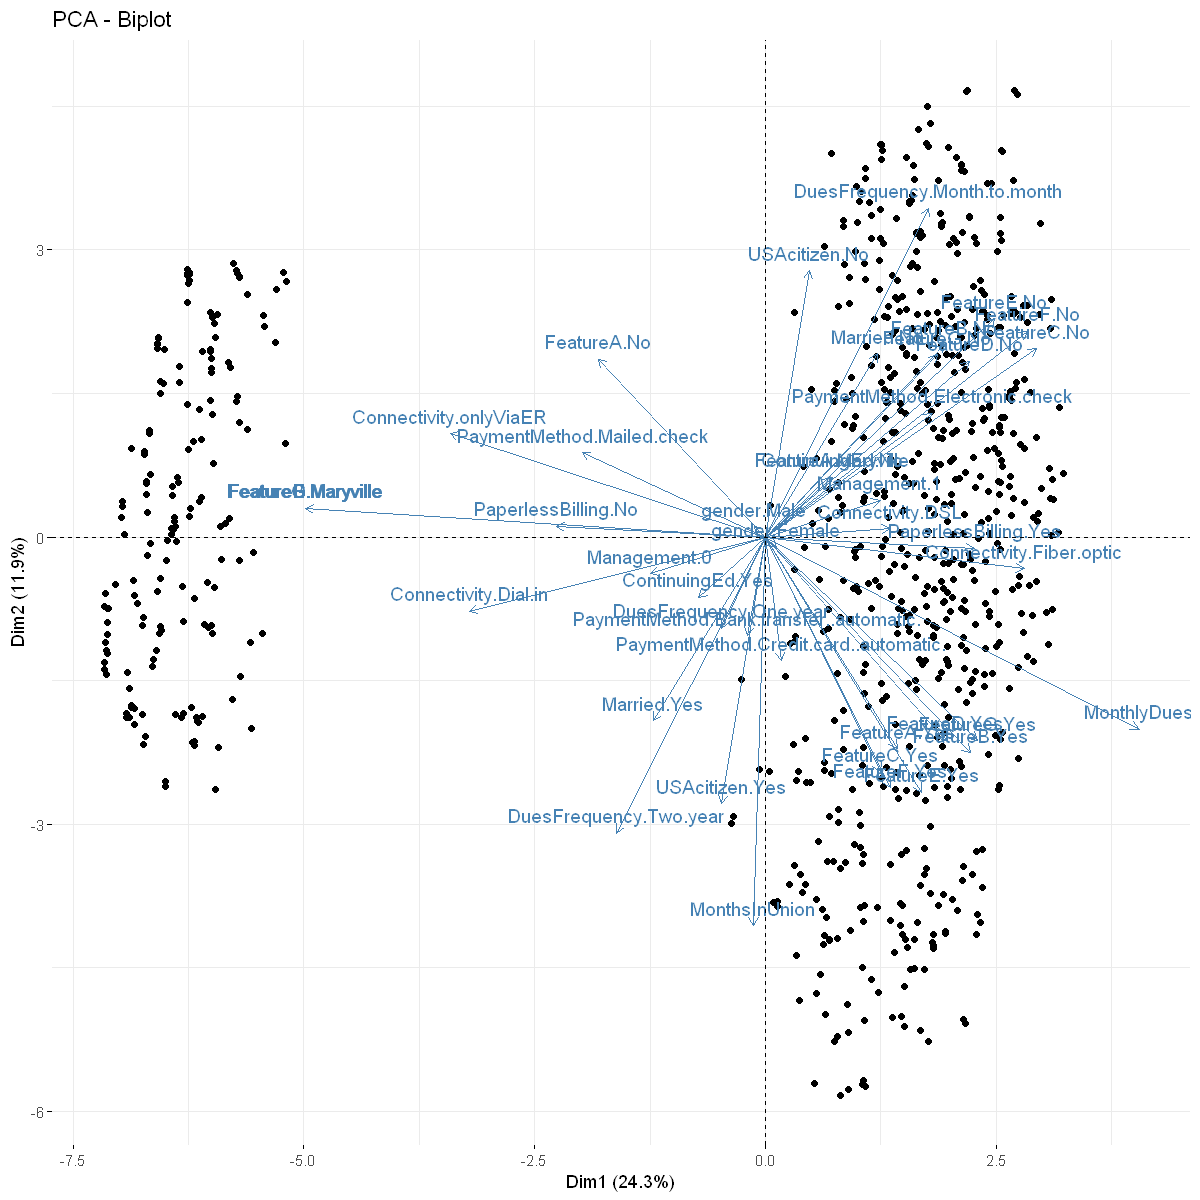

In [28]:
res.pca <- prcomp(train_final[, -ncol(train_final)], scale = TRUE)
# Biplot with active variables labeled
options(repr.plot.width=10, repr.plot.height=10)
fviz_pca_biplot(res.pca, label='var')

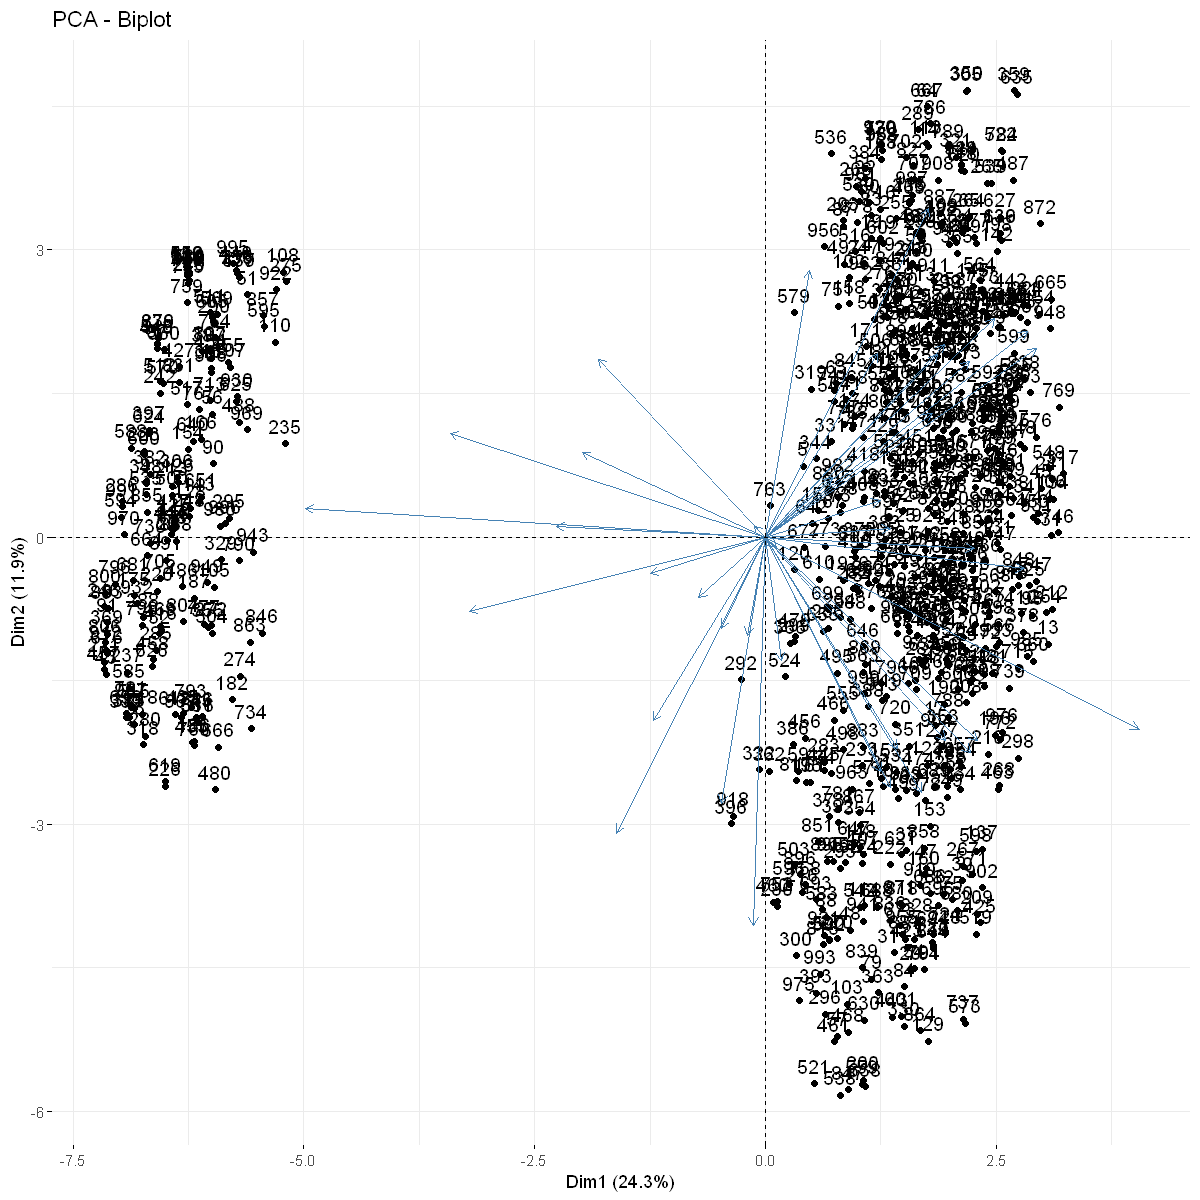

In [29]:
# Biplot with active individuals labeled
fviz_pca_biplot(res.pca, label='ind')

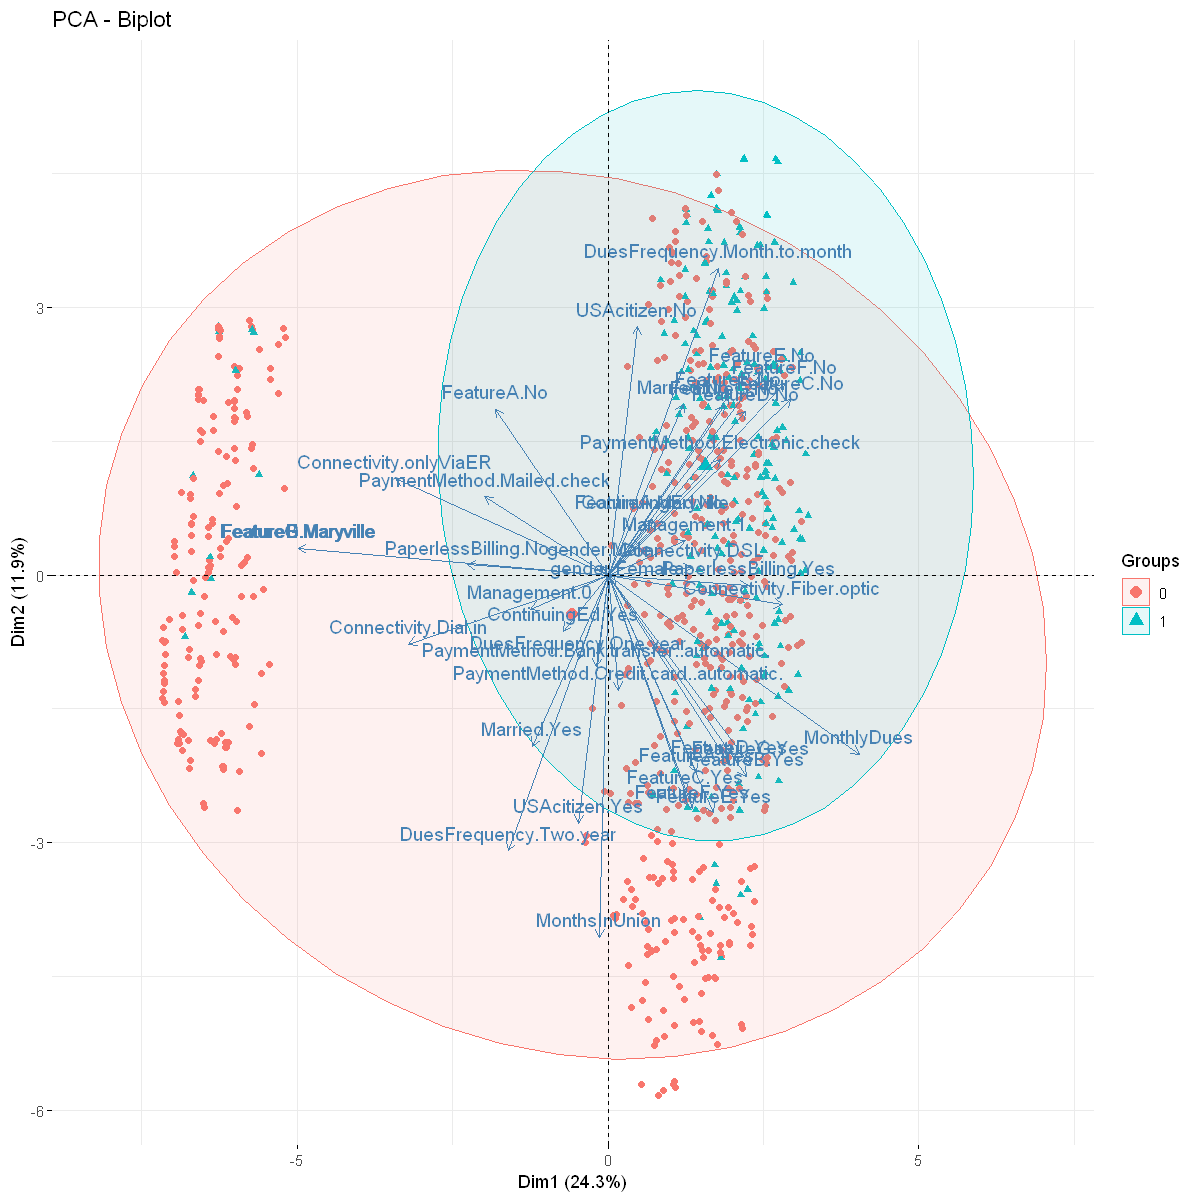

In [30]:
# Biplot with left union (1) vs not left union (0) groups in ellipses and colored
fviz_pca_biplot(res.pca, label='var', habillage=train_final$LeftUnion, addEllipses=TRUE, ellipse.level=0.90)

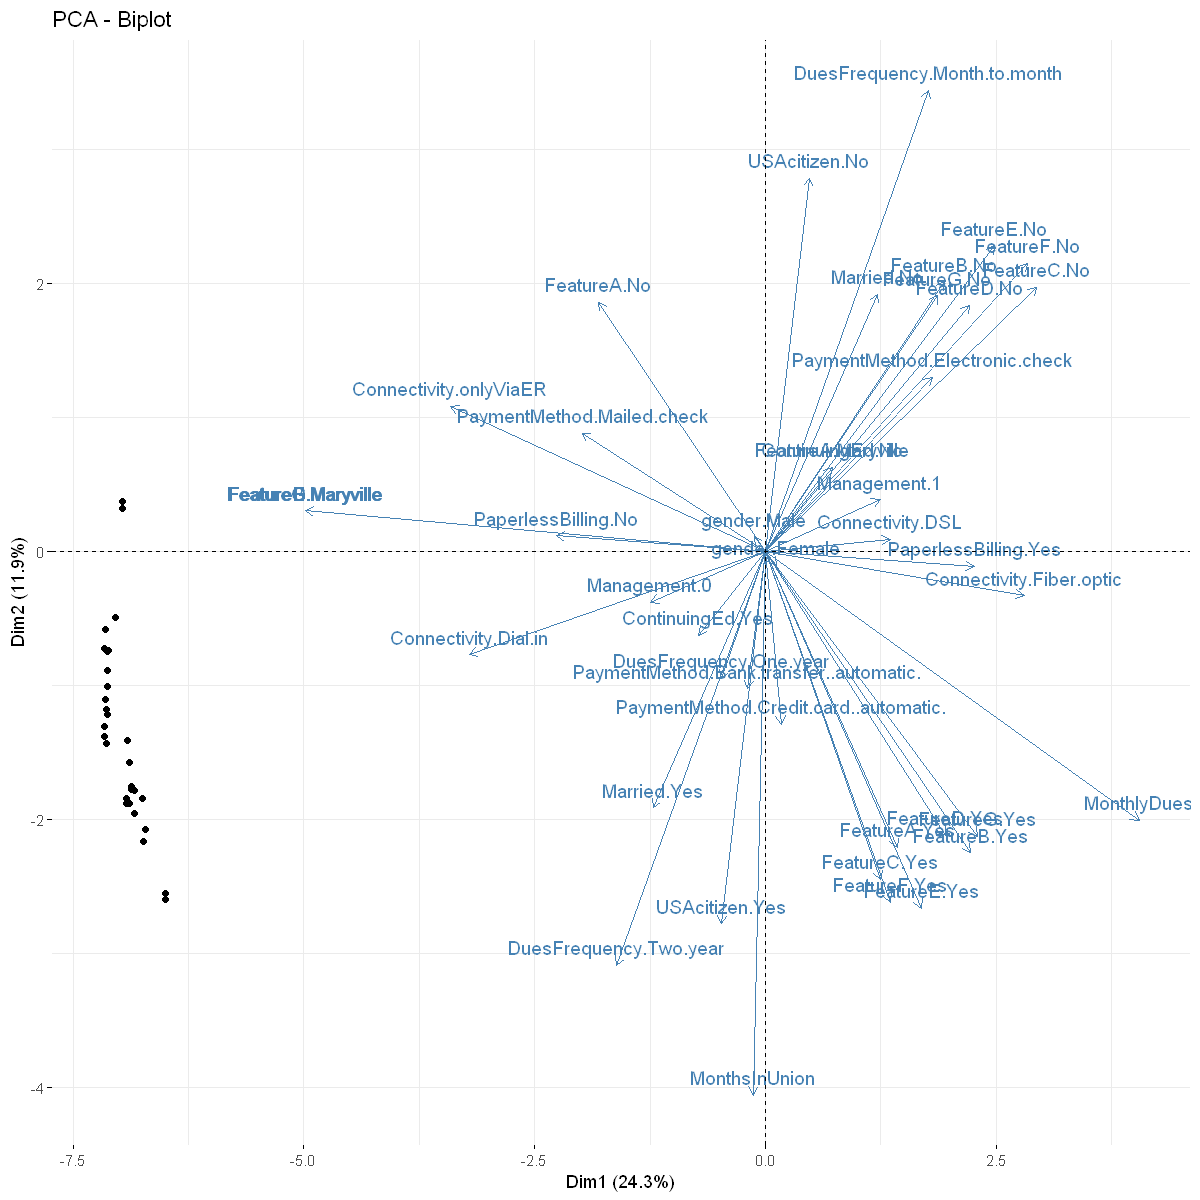

In [31]:
# Biplot showing the top 30 individuals with the highest contribution
fviz_pca_biplot(res.pca, label='var', select.ind=list(contrib=30))

##### The PCA biplots show that FeatureB.Maryville strongly influences PC1 and MonthInUnion and MonthlyDues strongly influence PC2. 

### Part 4: Binomial Generalized Linear Classification Model
##### The first model I will train is a binomial GLM classification model using the principal components I created. A binomial GLM is a model which relates a binary outcome variable, LeftUnion, to a linear combination of feature variables, which in this case are the first 17 principal components. 

In [32]:
# Create df of training data to be used in models
pca_train <- predict(pca,train_final)
pca_train <- data.frame(pca_train, train_final[ncol(train_final)])

In [33]:
# Training the GLM model using the first 17 principal components which accounts for 93% of the total variance
glm_model <- glm(LeftUnion ~ PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13+PC14+PC15+PC16+PC17, data=pca_train, family='binomial')
summary(glm_model)


Call:
glm(formula = LeftUnion ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + 
    PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + PC14 + PC15 + 
    PC16 + PC17, family = "binomial", data = pca_train)

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.6859013  0.1586759 -10.625  < 2e-16 ***
PC1          0.3463642  0.0600393   5.769 7.98e-09 ***
PC2          0.4740588  0.0603146   7.860 3.85e-15 ***
PC3         -0.2225643  0.0475397  -4.682 2.85e-06 ***
PC4         -0.0113842  0.0617128  -0.184  0.85364    
PC5         -0.1854929  0.0640177  -2.898  0.00376 ** 
PC6         -0.4020872  0.1008783  -3.986 6.72e-05 ***
PC7         -0.1638753  0.0855978  -1.914  0.05556 .  
PC8         -0.0002705  0.0988141  -0.003  0.99782    
PC9         -0.0076130  0.0946478  -0.080  0.93589    
PC10         0.1316671  0.0865231   1.522  0.12807    
PC11        -0.1452481  0.0860861  -1.687  0.09156 .  
PC12         0.0642135  0.0877281   0.732  0.46419    
PC13         0.1355713  

##### Next, I generate predictions for LeftUnion using the GLM model I trained and calculate the optimal cutoff as opposed to using 0.5 via the optimalCutoff function from the library, InformationValue. I compare the predictions with the actual response variable, LeftUnion, in order to determine the accuracy of the model. 

In [34]:
# Calculate probability of leaving union for each observation in training dataset
glm_pred_train <- predict(glm_model, pca_train, type='response')

In [35]:
# Find optimal cutoff probability to use to maximize accuracy
optimal <- optimalCutoff(pca_train$LeftUnion, glm_pred_train)[1]
optimal

[1] 0.5056169

In [36]:
# Create new column, pred, in train_final using the optimal cutoff found above
train_final$pred <- ifelse(glm_pred_train >= optimal, 1, 0)
# Generating the confusion matrix
tab_glm_train <- table(train_final$pred, train_final$LeftUnion)
tab_glm_train

   
      0   1
  0 522 102
  1  65 109

In [37]:
# Calculate accuracy of glm model on training set
accuracy_glm_train <- sum(diag(tab_glm_train))/sum(tab_glm_train)*100
round(accuracy_glm_train,2)

[1] 79.07

##### I obtain an accuracy of 79.07% for my GLM model on the training set. Next, I will check the accuracy for the validation set. 

In [38]:
# Create df of validation data to be used in models
pca_valid <- predict(pca,valid_final)
pca_valid <- data.frame(pca_valid, valid_final[ncol(valid_final)])

In [39]:
# Calculate probability of leaving union for each observation in validation dataset
glm_pred_valid <- predict(glm_model, pca_valid, type='response')
# Create new column, pred, in valid_final using the optimal cutoff found above
valid_final$pred <- ifelse(glm_pred_valid >= optimal, 1, 0)
# Generating the confusion matrix
tab_valid <- table(valid_final$pred, valid_final$LeftUnion)
tab_valid

   
      0   1
  0 133  22
  1  18  25

In [40]:
# Calculate accuracy of glm model on validation set
accuracy_glm_valid <- sum(diag(tab_valid))/sum(tab_valid)*100
round(accuracy_glm_valid,2)

[1] 79.8

##### I obtain a good accuracy of 79.8% for my GLM model on the validation set. 

### Part 5: Neural Network Model
##### Neural networks are a type of machine learning algorithm which mimic the functionality of a human brain's neurons. Forward propagation takes the weighted sums of inputs through activation functions and hidden layers to output one of N categories for classification. The predictions are compared with the known category to calculate a cost function. Finally backpropagation is the process where each iteration makes adjustments to the weights. The combination of these processes make up a neural network model. 
##### A general methodology I found is to use 1 to 2 hidden layers, with the number of neurons equaling 2/3 of the input size. With 17 input components, I will use 11 neurons and for the sake of run time, only one hidden layer. 

In [41]:
# Train the neural network
neural_network <- neuralnet(LeftUnion~PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13+PC14+PC15+PC16+PC17, data=pca_train, hidden=11, act.fct='logistic', linear.output=FALSE, stepmax=1e6)

In [42]:
# Remove LeftUnion from training and validation data 
pca_trainr <- subset(pca_train, select=-ncol(pca_train))
pca_validr <- subset(pca_valid, select=-ncol(pca_valid))

In [43]:
# Generate and display predictions from neural network
nn_pred_train <- compute(neural_network, pca_trainr)
nn_pred_valid <- compute(neural_network, pca_validr) 
head(nn_pred_train$net.result)
head(nn_pred_valid$net.result)

1,1.000000e+00,1.040444e-50
2,1.000000e+00,4.032286e-65
3,1.000000e+00,2.028367e-69
5,1.000000e+00,1.137799e-122
8,5.210716e-70,1.000000e+00
9,1.000000e+00,1.650489e-123


4,5.039522e-08,9.999999e-01
6,1.000000e+00,1.269221e-29
7,1.000000e+00,3.781946e-114
18,1.417841e-11,1.000000e+00
21,1.000000e+00,3.519208e-79
29,2.132323e-93,1.000000e+00


##### Next, I round the calculated predictions for LeftUnion to 0 or 1 and compute the accuracy on the training and validation data. 

In [44]:
# Round the predictions to 1 or 0 using the second column from net.result which represents the calculated percentage chance of leaving the union
nn_pred_train_round <- round(nn_pred_train$net.result[,2])
nn_pred_valid_round <- round(nn_pred_valid$net.result[,2])
head(nn_pred_train_round)
head(nn_pred_valid_round)

1 2 3 5 8 9 
0 0 0 0 1 0

4  6  7 18 21 29 
 1  0  0  1  0  1

In [45]:
# Calculate accuracy of neural network on training and validation sets 
round(mean(pca_train$LeftUnion == nn_pred_train_round)*100,2)
round(mean(pca_valid$LeftUnion == nn_pred_valid_round)*100,2)

[1] 96.99

[1] 71.72

##### I obtain a very high accuracy score on the training set of 96.99%, but the score on the validation set drops to 71.72%. Finally, I plot the neural network.

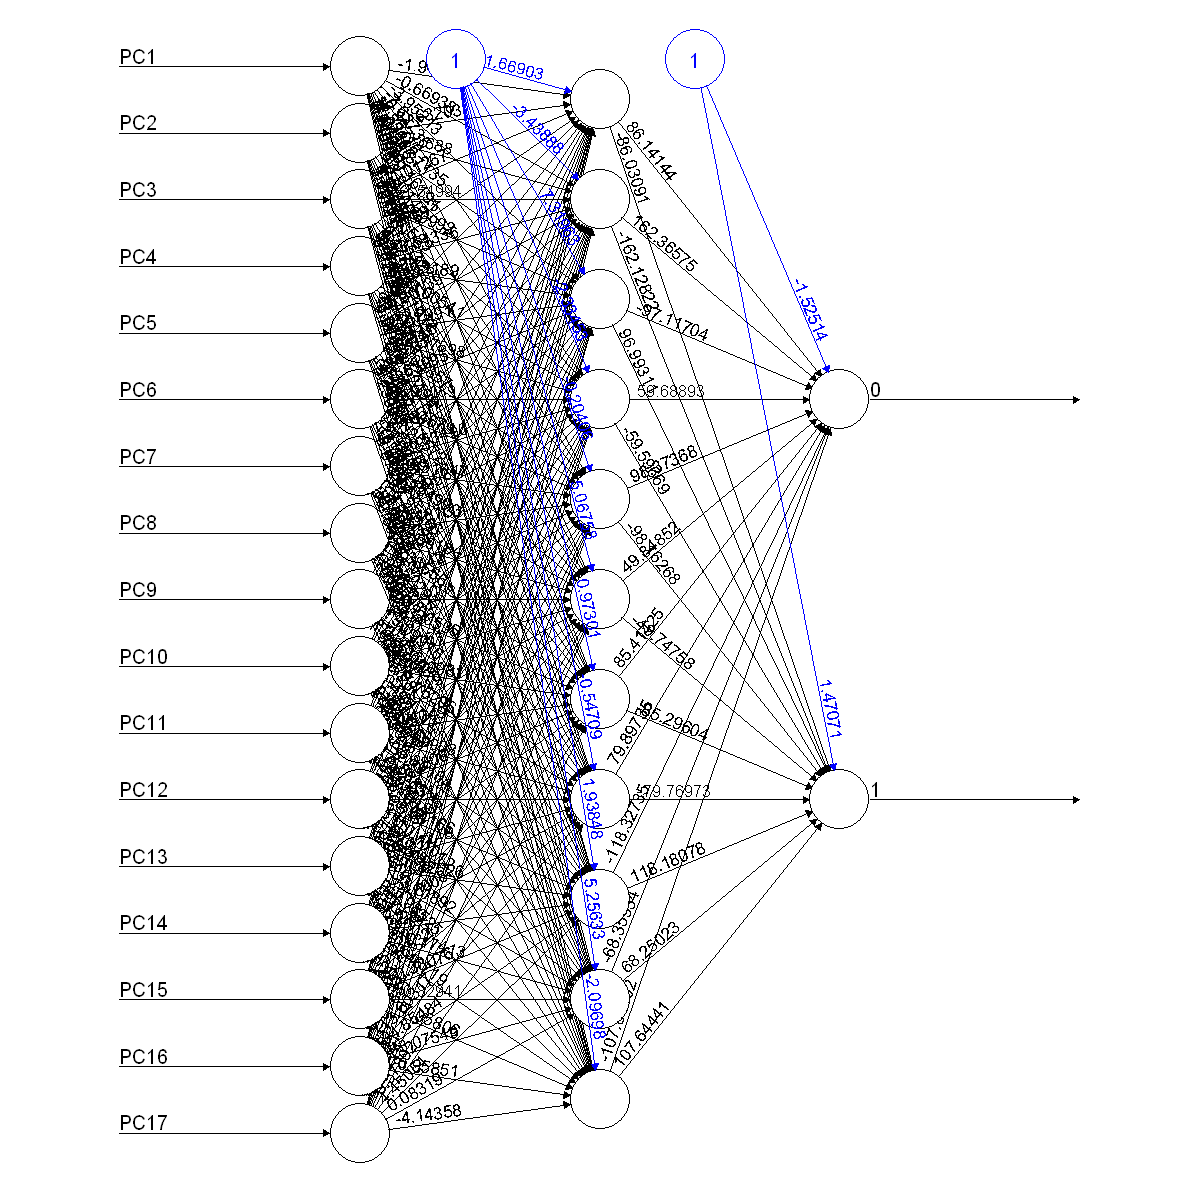

In [46]:
# Plot the neural network with the weights on each connection
plot(neural_network, rep='best')

### Part 6: Random Forest Model
##### Decision trees use the classification and regression tree method to determine split points for the trees. The split points are based on finding attributes that return the highest information gain, using the Gini Impurity method or Shannon Entropy. A random forest is as the name implies, a forest of several decision trees. The collection of weaker decision tree models is used to build a stronger random forest model. 
##### I use a random forest model as opposed to a decision tree to obtain a more robust solution which is not prone to overfitting the training data like a decision tree model would.

In [47]:
# Fit and view random forest model
set.seed(1)
rf_model <- randomForest(LeftUnion~PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13+PC14+PC15+PC16+PC17, data=pca_train)
rf_model


Call:
 randomForest(formula = LeftUnion ~ PC1 + PC2 + PC3 + PC4 + PC5 +      PC6 + PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + PC14 +      PC15 + PC16 + PC17, data = pca_train) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 4

        OOB estimate of  error rate: 25.06%
Confusion matrix:
    0  1 class.error
0 527 60   0.1022147
1 140 71   0.6635071

OOB,0,1
0.2983051,0.1906977,0.5875000
0.3090129,0.1791045,0.6412214
0.3063973,0.1736111,0.6604938
0.3082822,0.1797040,0.6480447
0.2984218,0.1689587,0.6489362
0.2924528,0.1681901,0.6410256


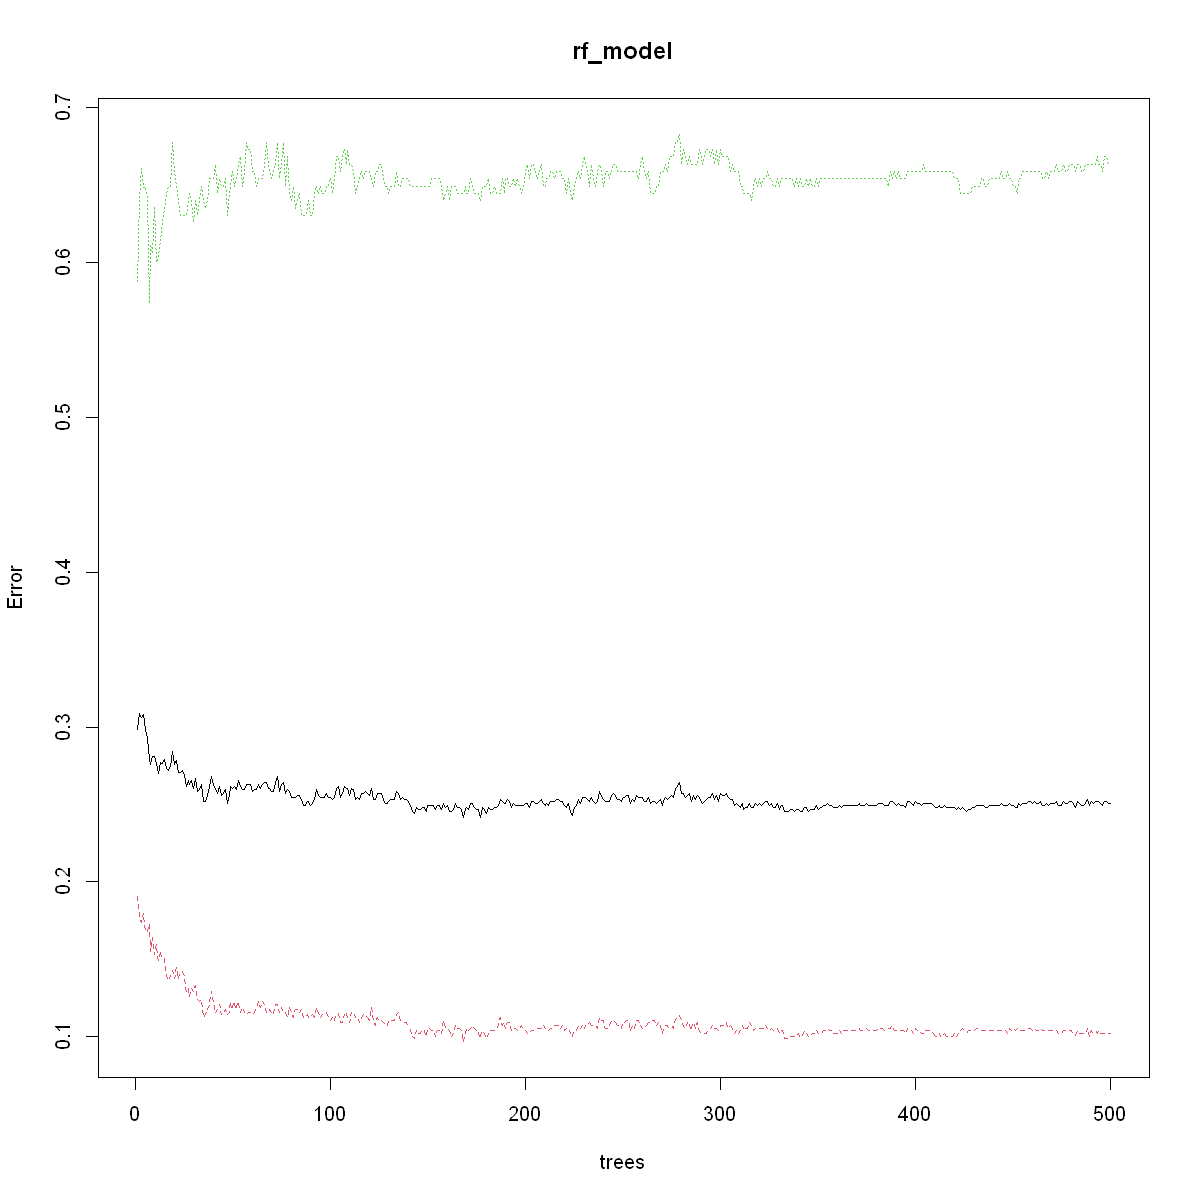

In [48]:
# Plot of out-of-bag error rates vs number of trees
head((plot(rf_model)))
plot(rf_model)

##### The top line represent the OOB error rate for predicting left the union, the middle line represents the overall OOB error rate, and the bottom line represents the OOB error rate for predicting did not leave the union. Note the predictions for left the union exhibit high estimated error rates between 0.6 to 0.7. 

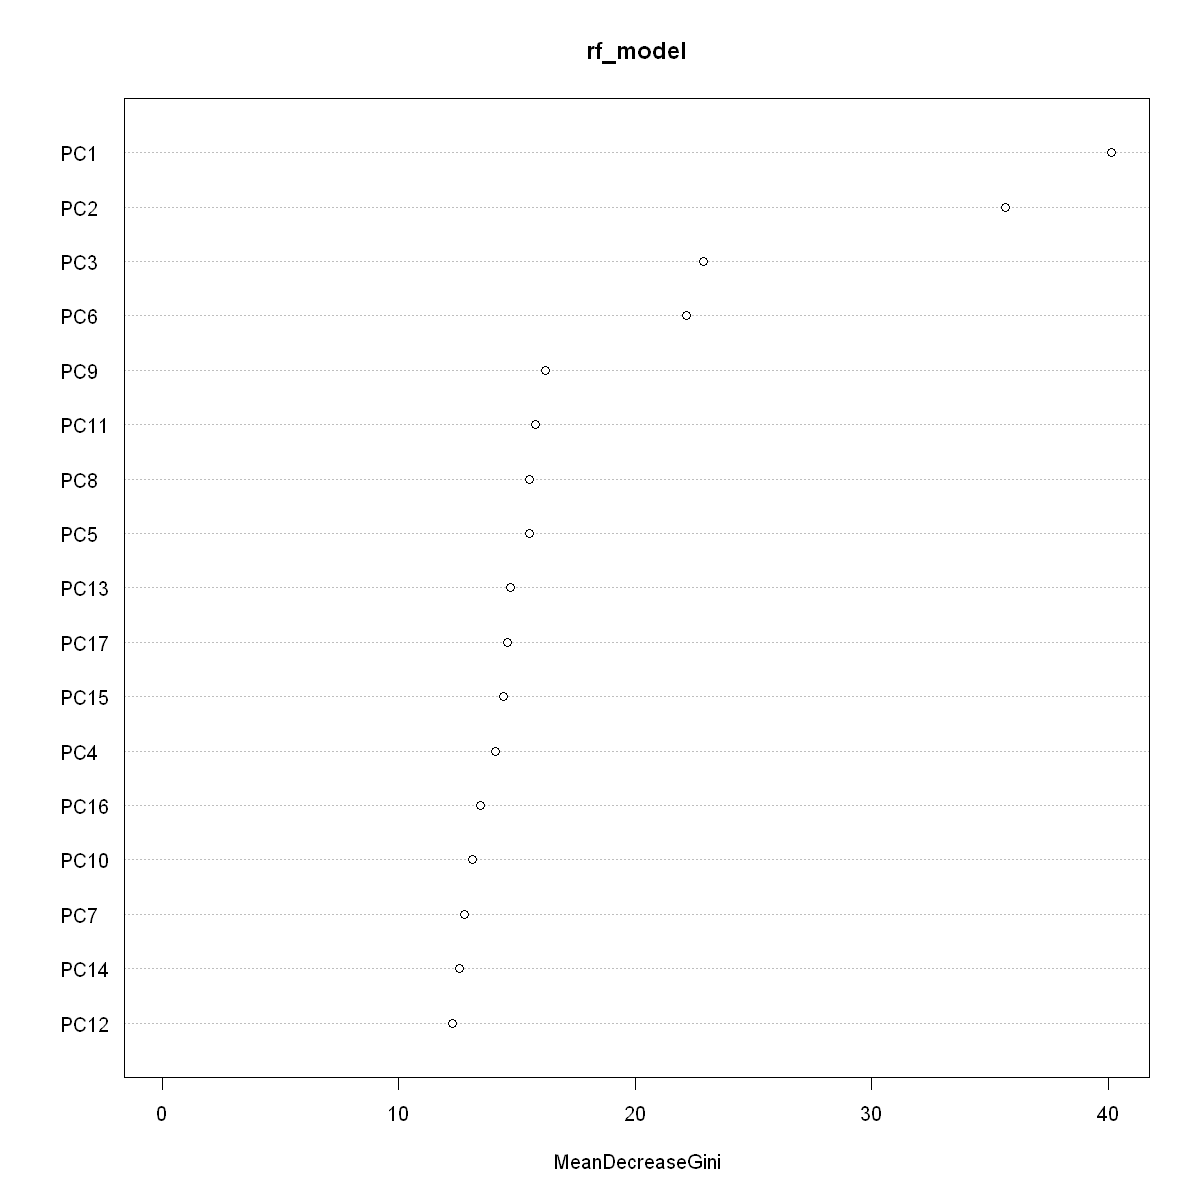

In [49]:
# Plot of the importance of each principal component
varImpPlot(rf_model) 

##### The plot shows the importance of each principal component in our model as denoted by the mean decrease in Gini. The top 3 most important variables are the first 3 principal components, but the order does not follow as the 4th highest mean decrease in Gini is from PC6. Next, I generate predictions using my random forest model and compute accuracy scores for the training and validation sets. 

In [50]:
# Generate predictions using random forest model for training and validation sets
rf_train_pred <- predict(rf_model, newdata=pca_trainr)
rf_valid_pred <- predict(rf_model, newdata=pca_validr)

In [51]:
# Calculate accuracy of random forest model on training and validation sets 
round(100*mean(pca_train$LeftUnion == rf_train_pred),2)
round(100*mean(pca_valid$LeftUnion == rf_valid_pred),2)

[1] 99.37

[1] 77.78

##### The random forest model yielded a very high accuracy of 99.37% on the training set and an okay accuracy of 77.78% on the validation set. Next, I tune mtry (number of variables sampled at each split) using tuneRF(). Note randomForest() sets mtry to the square root of the number of features for random forest classification, which in this case equals 4. 

mtry = 6  OOB error = 25.56% 
Searching left ...
mtry = 3 	OOB error = 24.81% 
0.02941176 0.05 
Searching right ...
mtry = 12 	OOB error = 25.31% 
0.009803922 0.05 
       mtry  OOBError
3.OOB     3 0.2481203
6.OOB     6 0.2556391
12.OOB   12 0.2531328


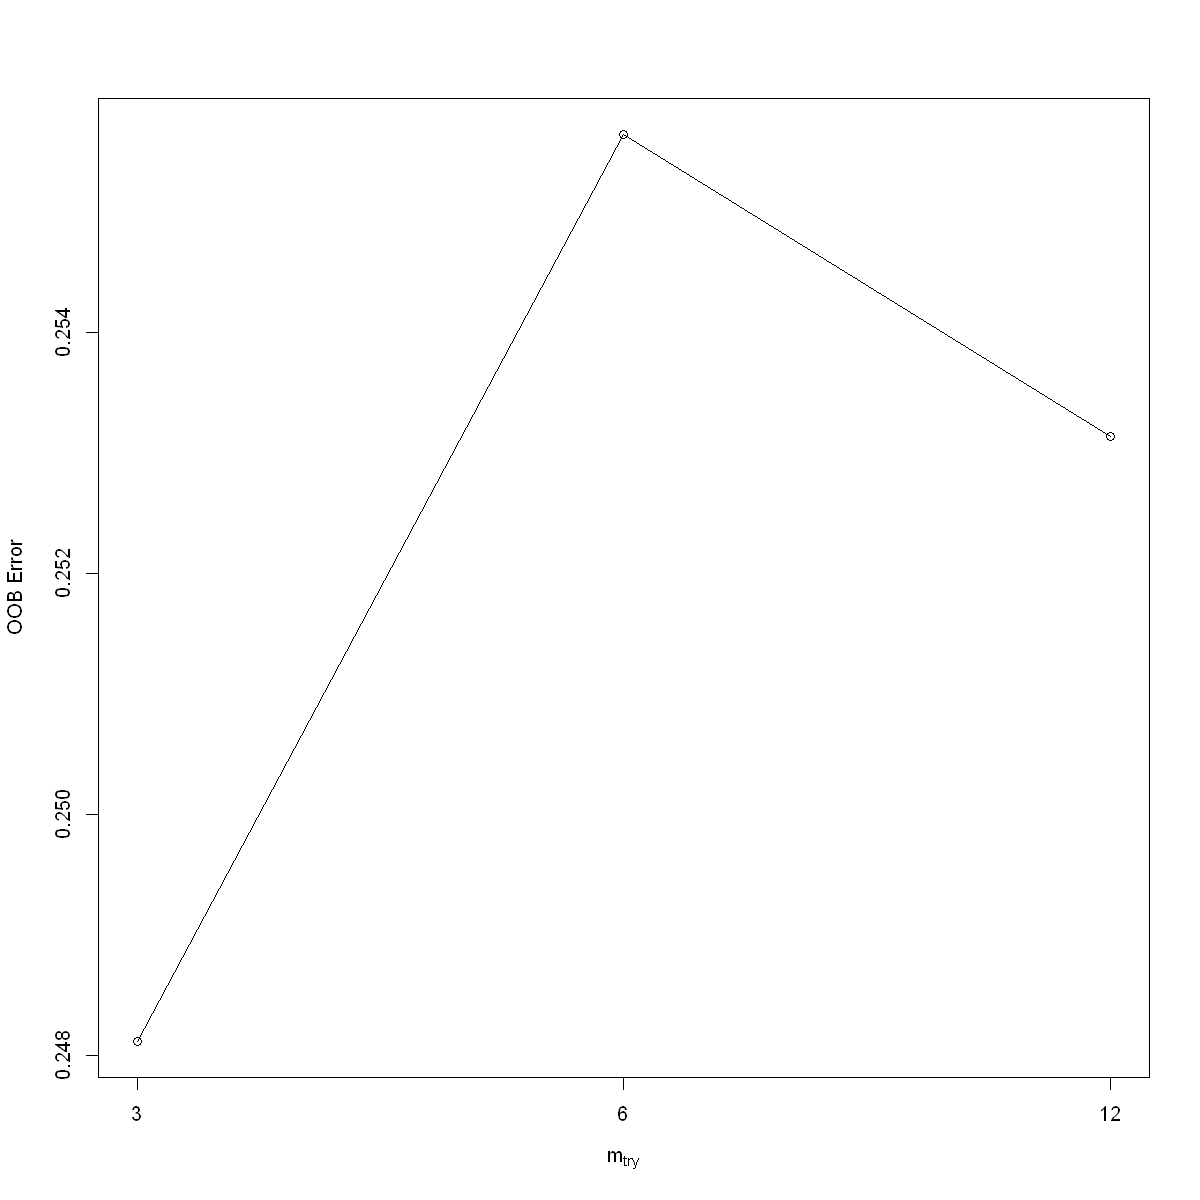

In [52]:
set.seed(1)
bestrf <- tuneRF(pca_trainr, pca_train$LeftUnion, stepfactor = 1, improve = .05)
print(bestrf)

##### Mtry = 3 yielded the lowest OOB error rate, so I will fit another random forest model with that setting. 

In [53]:
set.seed(1)
rf_model_new <- randomForest(LeftUnion~PC1+PC2+PC3+PC4+PC5+PC6+PC7+PC8+PC9+PC10+PC11+PC12+PC13+PC14+PC15+PC16+PC17, data=pca_train, mtry=3)
rf_model_new


Call:
 randomForest(formula = LeftUnion ~ PC1 + PC2 + PC3 + PC4 + PC5 +      PC6 + PC7 + PC8 + PC9 + PC10 + PC11 + PC12 + PC13 + PC14 +      PC15 + PC16 + PC17, data = pca_train, mtry = 3) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 3

        OOB estimate of  error rate: 25.19%
Confusion matrix:
    0  1 class.error
0 531 56  0.09540034
1 145 66  0.68720379

In [54]:
# Generate predictions using random forest model for training and validation sets
rf_train_newpred <- predict(rf_model_new, newdata=pca_trainr)
rf_valid_newpred <- predict(rf_model_new, newdata=pca_validr)
# Calculate accuracy of random forest model on training and validation sets 
round(100*mean(pca_train$LeftUnion == rf_train_newpred),2)
round(100*mean(pca_valid$LeftUnion == rf_valid_newpred),2)

[1] 99.37

[1] 78.79

##### The new random forest model yielded the same accuracy of 99.37% on the training set and a slight improvement of 77.78% to 78.79% on the validation set.

### Part 7: Support Vector Machine
##### A support vector machine is a linear classification technique involving the separation of data (decision boundary) into classes by finding the hyperplane of maximum distance from two classes at a time. This distance is known as the margin and SVMs are designed to maximize the margin. For non-linear decision boundaries, the kernal of a SVM model can be set to a transformation function, such as the radial basis function. The transformation involves generating new features by measuring the distance between all other points to a specific point or center. 
##### I begin by creating, fitting, and scoring the accuracy of a base SVM model. 

In [55]:
svm_model <- svm(x=pca_trainr, y=pca_train$LeftUnion, type='C-classification')
summary(svm_model)


Call:
svm.default(x = pca_trainr, y = pca_train$LeftUnion, type = "C-classification")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  465

 ( 265 200 )


Number of Classes:  2 

Levels: 
 0 1




In [56]:
# Generate predictions on training set
pred_svm <- predict(svm_model, pca_trainr)

In [57]:
# Confusion matrix
tab_svm <- table(pred_svm, pca_train$LeftUnion)
tab_svm

        
pred_svm   0   1
       0 561  88
       1  26 123

In [58]:
# Compute accuracy of SVM model
round(sum(diag(tab_svm))/sum(tab_svm)*100,2)

[1] 85.71

##### I obtain an accuracy of 85.71%, which is good but I can do better. SVMs use cost and gamma hyper-parameters to tune the wiggling of the decision boundaries. Cost is a regularization parameter which penalizes the model for misclassifications. Higher cost settings result in less wiggling. Gamma controls the influence that feature data points have on the decision boundary. Higher gamma results in more wiggling. Tuning these hyper-parameters is pivotal to building a SVM model, which is what I will do next. 

In [59]:
svm_tune <- tune(svm, train.x=pca_trainr, train.y=pca_train$LeftUnion, kernel="radial", ranges=list(cost=10^(-2:2), gamma=c(.1,.25,.5,1,2)))
svm_tune


Parameter tuning of 'svm':

- sampling method: 10-fold cross validation 

- best parameters:
 cost gamma
   10  0.25

- best performance: 0.2531171 


##### I refit my SVM model using the optimal cost and gamma parameters I found above. 

In [60]:
svm_model_final <- svm(x=pca_trainr,y=pca_train$LeftUnion,type='C-classification',cost=10,gamma=0.25)
summary(svm_model_final)


Call:
svm.default(x = pca_trainr, y = pca_train$LeftUnion, type = "C-classification", 
    gamma = 0.25, cost = 10)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  10 

Number of Support Vectors:  776

 ( 566 210 )


Number of Classes:  2 

Levels: 
 0 1




In [61]:
# Generate predictions for final SVM model on training set
pred_svm_tune <- predict(svm_model_final,pca_trainr)
# Confusion matrix
tab_svm_tune <- table(pred_svm_tune,pca_train$LeftUnion)
tab_svm_tune

             
pred_svm_tune   0   1
            0 586   8
            1   1 203

In [62]:
# Accuracy of final SVM model on training set
round(sum(diag(tab_svm_tune))/sum(tab_svm_tune)*100,2)

[1] 98.87

##### I see a significant increase in accuracy on the training set after tuning, increasing accuracy from 85.71% to 98.87%. Finally, I generate predictions on the validation set and check its accuracy score. 

In [63]:
# Generate predictions for validation set
pred_svm_valid <- predict(svm_model_final,pca_validr)
# Confusion matrix
tab_svm_valid <- table(pred_svm_valid,pca_valid$LeftUnion)
tab_svm_valid

              
pred_svm_valid   0   1
             0 149  45
             1   2   2

In [64]:
# Accuracy of validation set
round(sum(diag(tab_svm_valid))/sum(tab_svm_valid)*100,2)

[1] 76.26

##### Note there is a marked decrease in accuracy between the training and validation sets, from to 98.87% 76.26%.

### Part 8: Conclusion

##### I trained 4 different models: a generalized linear model, neural network, random forest, and support vector machine, in order to predict the union status (leave or did not leave union) of hypothetical individuals in the dataset. Between the accuracy scores of each model on the validation set, the highest score belongs to the GLM model at 79.8%. The GLM model also produced the lowest training accuracy score of 79.07%. The second highest validation set accuracy score belongs to the random forest model at 78.79%, which also had the highest training set accuracy score of 99.37%. If I had to pick one model out of the four, I would choose the random forest model which had the highest training set accuracy score and second highest validation set accuracy score. If I had more time, I would have liked to check the accuracy of my four models on the original test dataset and pick the best model as the one with the highest test set accuracy score. 

##### Question: Comparing your results, to that of a blind guess, explain why you think the results differed?
##### If I were to guess No for every individual in the no-outlier 996 observation training set, then I would obtain an accuracy of 74.1% (738/996). Note that all of my models' accuracy scores other than the neural network's validation set accuracy are higher than 74.1%. Of course, this type of guessing methodology would lead to a skewed distribution for predictions with 100% accuracy for did not leave the union and 0% accuracy for left the union. Moreover, it is not always possible to know the exact distribution of classifications for your response variable and so the hypothetical accuracy of 74.1% would be higher than an actual blind guess. 
##### In general, machine learning models are designed to fit and train a model to data with the goal of expanding the fitted model to unseen data (test sets). A true blind guess is based on no previous information, whereas machine learning models train on datasets in order to create a fitted model. The type of training can be supervised (response variable values are known) or unsupervised (response variable values are unknown). In this project's case, the original training dataset contained values for LeftUnion, the response variable. Thus, one of the reasons the results differed is because of access to training data, which a person making a blind guess would not have. 
##### A blind guess also does not follow any set methodology other than whatever a person feels like guessing. The four models I used employ clear methodologies, with decades of research and improvements, all backed by empirical mathematical calculations. The general methodology of the models was included at the start of each modeling section and so, I will not be repeating it here. In conclusion, another reason the results differed is because models employ clear methodologies backed by research and math, which a blind guess does not do. 

##### Question: Describe how you would improve your project if you had more time?
##### One of the keys to building a good machine learning model is hyper-parameter tuning. The glm() function has no tunable hyper-parameters. In my neural network model, I chose the number of hidden layers (1) and neurons (11) based on general methodology I read online. A better, though extensively more time-consuming method would have been to cycle through different combinations of hidden layers and neurons to find the model with the highest validation or test accuracy score. For the random forest model, I tuned mtry using tuneRF(). However, I obtained only a marginally higher accuracy score on the validation set. Given more time, I could have used other tuning methods like GridSearch or tune other hyper-parameters in randomForest() like ntree. Finally, I was able to tune cost and gamma in the SVM using the tune() function, which increased the training set accuracy from 85.71% to 98.87%. It may not be possible to perfectly tune every model, but given more time I could have improved on the tuning I did. 
##### I would also have liked to create my models using not only principal component analysis, but the original features in the dataset as well. One of the biggest disadvantages of using PCA is that the principal components are hard to describe compared to the original features like gender or MonthlyDues. Fitting models using the original features may or may not yield higher accuracy scores, but it will at least make the results of the model much easier to explain in real-world terms. One thing to note is that I would have to standardize MonthlyDues and MonthsInUnion separately such that distance measurements are not influenced by high nominal values. In my analysis, I used the center and scale parameters in prcomp() to standardize the dataset.
##### An autoencoder neural network is designed to produce a replica of its input and is an alternative to other dimensionality reduction methods like PCA. They also excel at spotting anomalies in new data once trained. Another benefit is autoencoder neural network models can directly go back to the original dimensions unlike PCA. Given more time, I would have liked to compare an autoencoder neural network to PCA in my analysis. 
##### Finally, I could have expanded on the types of models I did use. For example, in addition to my GLM model, I could have tried a boosted GLM model, which involves adding to the model iteratively. Given more time, I could have also tried combining models, such as combining random forest and neural network to hopefully create an even more powerful ensemble model. 
